# Cross-Lingual Transferability of Voice Analysis Models: a Parkinson's Disease Case Study

## Preliminaries

### Imports

In [2]:
from typing import Tuple, List, Dict, Union, Optional

In [3]:
import os
from ast import literal_eval
import datetime

In [4]:
import numpy as np
import pandas as pd
import librosa

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

### Constants

In [21]:
EN_DATA_DIR: str = '../resources/data/Split_denoised_english'
EN_METADATA_FILE: str = '../resources/data/Split_denoised_english/metadata.csv'
HI_DATA_DIR: str = '../resources/data/Split_denoised_hindi'
HI_METADATA_FILE: str = '../resources/data/Split_denoised_hindi/metadata.csv'

In [39]:
EN_TO_HI_EXPERIMENTS_DIR: str = '../'
HI_TO_EN_EXPERIMENTS_DIR: str = '../'
    #sta nella cartella base del progetto score.csv

In [18]:
OUT_DIR_PATH: str = '../experiments/results'
if not os.path.exists(OUT_DIR_PATH):
    os.mkdir(OUT_DIR_PATH)

In [9]:
LABEL_MAPPING: Dict[str, str] = {
    'healthy': 'Healthy conditions',
    'unhealthy': 'Parkinson\'s disease'
}
FEATURES_MAPPING: Dict[str, str] = {
    'spectral': 'Acoustic and Spectral',
    'vggish': 'VGGish',
    'soundnet': 'SoundNet',
    'wav2vec': 'Wav2Vec 2.0'
}
POOLING_MAPPING: Dict[str, str] = {
    'avg': 'Avg. pooling',
    'max': 'Max pooling',
    'flatten': 'Flattening'
}
ADAPTATION_MAPPING: Dict[bool, str] = {
    False: 'None',
    True: 'CORrelation ALignment (CORAL)'
}
DATA_MAPPING: Dict[str, str] = {
    'src': 'Source data (test split)',
    'tgt': 'Target data'
}
METRICS_MAPPING: Dict[str, str] = {
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'fscore': '$F_1$-score',
    'specificity': 'Specificity',
    'roc_auc': 'ROC AUC',
    'support': 'Support',
    'fpr': 'False positives rate',
    'tpr': 'True postives rate',
    'roc_thresholds': 'Threshold (from ROC curve)',
    'precisions': 'Precision score',
    'recalls': 'Recall score',
    'pr_rc_thresholds': 'Threshold (from precision-recall curve)',
    'confusion_matrix': 'Confusion matrix'
}

In [10]:
METRICS = ['Accuracy', 'Precision', 'Recall', '$F_1$-score', 'Specificity', 'ROC AUC']
ROC = ['False positives rate', 'True postives rate', 'Threshold (from ROC curve)']
PRC_REC = ['Precision score', 'Recall score', 'Threshold (from precision-recall curve)']
CONF_MAT = ['Confusion matrix']

In [11]:
DF_COLUMNS: List[str] = ['Input features', 'Pooling approach', 'Domain adaptation', 'Data set', 'Metric', 'Value']

### Utility function(s)

In [12]:
def get_duration(path: str) -> Optional[float]:
    if os.path.exists(path):
        return librosa.get_duration(filename=path)
    else:
        return None

In [13]:
def convert_series(raw_series: pd.Series) -> Tuple[
    str, str, str, str, str, Union[float, int, List[float], List[List[int]]]
]:
    feature: str = FEATURES_MAPPING[raw_series['feature']]
    pooling: str = POOLING_MAPPING[raw_series['pooling']]
    adaptation: str = ADAPTATION_MAPPING[raw_series['adaptation']]
    data: str = DATA_MAPPING[raw_series['data_set']]
    metric: str = METRICS_MAPPING[raw_series['metric']]
    value = literal_eval(raw_series['value'])
    
    return feature, pooling, adaptation, data, metric, value

In [14]:
def convert_results_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    df: pd.DataFrame = pd.DataFrame(
        [convert_series(row) for _, row in raw_df.iterrows()], columns=DF_COLUMNS
    )

    return df

## Data

Load data

In [19]:
df_en_metadata: pd.DataFrame = pd.read_csv(EN_METADATA_FILE, )
df_en_metadata['Language'] = 'English'
df_en_metadata['Label'] = df_en_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_en_metadata.sample(10)

file_name      label  \
184             ReadText/PD/ID06_pd_3_1_1_000.wav  unhealthy   
42              ReadText/HC/ID09_hc_0_0_0_004.wav    healthy   
213             ReadText/PD/ID16_pd_2_0_0_004.wav  unhealthy   
170             ReadText/PD/ID02_pd_2_0_0_003.wav  unhealthy   
299  SpontaneousDialogue/HC/ID03_hc_0_0_0_000.wav    healthy   
162             ReadText/HC/ID36_hc_0_0_0_004.wav    healthy   
74              ReadText/HC/ID14_hc_0_0_0_005.wav    healthy   
142             ReadText/HC/ID28_hc_0_0_0_007.wav    healthy   
207             ReadText/PD/ID13_pd_3_2_2_003.wav  unhealthy   
335  SpontaneousDialogue/HC/ID12_hc_0_0_0_005.wav    healthy   

                           original_file_name    start_time      end_time  \
184             ReadText/PD/ID06_pd_3_1_1.wav  00:00:34.000  00:00:49.000   
42              ReadText/HC/ID09_hc_0_0_0.wav  00:01:31.000  00:01:43.000   
213             ReadText/PD/ID16_pd_2_0_0.wav  00:01:47.000  00:01:55.000   
170             ReadText/PD/ID02_pd_2_0_0.wav  00:00:51.000  00:01:01.000   
299  SpontaneousDialogue/HC/ID03_hc_0_0_0.wav  00:00:37.000  00:00:50.000   
162             ReadText/HC/ID36_hc_0_0_0.wav  00:01:32.000  00:01:45.000   
74              ReadText/HC/ID14_hc_0_0_0.wav  00:01:26.000  00:01:32.000   
142             ReadText/HC/ID28_hc_0_0_0.wav  00:02:10.000  00:02:23.000   
207             ReadText/PD/ID13_pd_3_2_2.wav  00:01:12.000  00:01:23.000   
335  SpontaneousDialogue/HC/ID12_hc_0_0_0.wav  00:02:13.000  00:02:23.000   

    Language                Label  
184  English  Parkinson's disease  
42   English   Healthy conditions  
213  English  Parkinson's disease  
170  English  Parkinson's disease  
299  English   Healthy conditions  
162  English   Healthy conditions  
74   English   Healthy conditions  
142  English   Healthy conditions  
207  English  Parkinson's disease  
335  English   Healthy conditions

In [22]:
df_hi_metadata: pd.DataFrame = pd.read_csv(HI_METADATA_FILE)
df_hi_metadata['Language'] = 'Hindi'
df_hi_metadata['Label'] = df_hi_metadata.apply(lambda r: LABEL_MAPPING[r['label']], axis=1)

df_hi_metadata.sample(10)

file_name      label  \
168  healthy-cv/common_voice_hi_340967370.wav    healthy   
74                       malakondaiah_003.wav  unhealthy   
92   healthy-cv/common_voice_hi_332435940.wav    healthy   
146  healthy-cv/common_voice_hi_340963230.wav    healthy   
192  healthy-cv/common_voice_hi_340975950.wav    healthy   
119  healthy-cv/common_voice_hi_337975430.wav    healthy   
149  healthy-cv/common_voice_hi_340963260.wav    healthy   
225  healthy-cv/common_voice_hi_346861400.wav    healthy   
69                      lakshmi pd ai_002.wav  unhealthy   
50                PTT-20210604-WA0005_000.wav  unhealthy   

          original_file_name    start_time      end_time Language  \
168                      NaN           NaN           NaN    Hindi   
74          malakondaiah.wav  00:00:36.000  00:00:44.000    Hindi   
92                       NaN           NaN           NaN    Hindi   
146                      NaN           NaN           NaN    Hindi   
192                      NaN           NaN           NaN    Hindi   
119                      NaN           NaN           NaN    Hindi   
149                      NaN           NaN           NaN    Hindi   
225                      NaN           NaN           NaN    Hindi   
69         lakshmi pd ai.wav  00:00:45.000  00:00:56.000    Hindi   
50   PTT-20210604-WA0005.wav  00:00:00.000  00:00:11.000    Hindi   

                   Label  
168   Healthy conditions  
74   Parkinson's disease  
92    Healthy conditions  
146   Healthy conditions  
192   Healthy conditions  
119   Healthy conditions  
149   Healthy conditions  
225   Healthy conditions  
69   Parkinson's disease  
50   Parkinson's disease

In [23]:
df_metadata = pd.concat([df_en_metadata, df_hi_metadata]).reset_index()

df_metadata.sample(10)

index                                     file_name      label  \
407    407  SpontaneousDialogue/PD/ID13_pd_3_2_2_003.wav  unhealthy   
120    120             ReadText/HC/ID25_hc_0_0_0_001.wav    healthy   
664    204      healthy-cv/common_voice_hi_340976950.wav    healthy   
628    168      healthy-cv/common_voice_hi_340967370.wav    healthy   
329    329  SpontaneousDialogue/HC/ID11_hc_0_0_0_003.wav    healthy   
392    392  SpontaneousDialogue/PD/ID06_pd_3_1_1_000.wav  unhealthy   
389    389  SpontaneousDialogue/PD/ID04_pd_2_0_1_000.wav  unhealthy   
243    243             ReadText/PD/ID24_pd_2_0_0_004.wav  unhealthy   
109    109             ReadText/HC/ID23_hc_0_0_0_000.wav    healthy   
282    282             ReadText/PD/ID34_pd_2_0_0_002.wav  unhealthy   

                           original_file_name    start_time      end_time  \
407  SpontaneousDialogue/PD/ID13_pd_3_2_2.wav  00:01:26.000  00:01:36.000   
120             ReadText/HC/ID25_hc_0_0_0.wav  00:00:37.000  00:00:49.000   
664                                       NaN           NaN           NaN   
628                                       NaN           NaN           NaN   
329  SpontaneousDialogue/HC/ID11_hc_0_0_0.wav  00:02:20.000  00:02:32.000   
392  SpontaneousDialogue/PD/ID06_pd_3_1_1.wav  00:00:25.000  00:00:37.000   
389  SpontaneousDialogue/PD/ID04_pd_2_0_1.wav  00:00:27.000  00:00:40.000   
243             ReadText/PD/ID24_pd_2_0_0.wav  00:01:33.000  00:01:45.000   
109             ReadText/HC/ID23_hc_0_0_0.wav  00:00:26.000  00:00:35.000   
282             ReadText/PD/ID34_pd_2_0_0.wav  00:00:46.000  00:01:00.000   

    Language                Label  
407  English  Parkinson's disease  
120  English   Healthy conditions  
664    Hindi   Healthy conditions  
628    Hindi   Healthy conditions  
329  English   Healthy conditions  
392  English  Parkinson's disease  
389  English  Parkinson's disease  
243  English  Parkinson's disease  
109  English   Healthy conditions  
282  English  Parkinson's disease

Distribution of duration (in seconds) of audio files

In [24]:
df_metadata['Duration [s]'] = df_metadata.apply(
    lambda r: get_duration(os.path.join(EN_DATA_DIR if r['Language'] == 'English' else HI_DATA_DIR, r['file_name'])), axis=1
)
df_metadata.sample(10)

index                                     file_name      label  \
319    319  SpontaneousDialogue/HC/ID09_hc_0_0_0_005.wav    healthy   
69      69             ReadText/HC/ID14_hc_0_0_0_000.wav    healthy   
174    174             ReadText/PD/ID02_pd_2_0_0_007.wav  unhealthy   
648    188      healthy-cv/common_voice_hi_340969480.wav    healthy   
508     48                   PTT-20210524-WA0021_002.wav  unhealthy   
495     35                   AUD-20210915-WA0020_002.wav  unhealthy   
260    260             ReadText/PD/ID30_pd_2_1_1_002.wav  unhealthy   
635    175      healthy-cv/common_voice_hi_340967960.wav    healthy   
106    106             ReadText/HC/ID22_hc_0_0_0_003.wav    healthy   
291    291  SpontaneousDialogue/HC/ID00_hc_0_0_0_002.wav    healthy   

                           original_file_name    start_time      end_time  \
319  SpontaneousDialogue/HC/ID09_hc_0_0_0.wav  00:01:39.000  00:01:49.000   
69              ReadText/HC/ID14_hc_0_0_0.wav  00:00:32.000  00:00:45.000   
174             ReadText/PD/ID02_pd_2_0_0.wav  00:01:48.000  00:02:02.000   
648                                       NaN           NaN           NaN   
508                   PTT-20210524-WA0021.wav  00:00:47.000  00:00:54.000   
495                   AUD-20210915-WA0020.wav  00:00:21.000  00:00:27.000   
260             ReadText/PD/ID30_pd_2_1_1.wav  00:00:41.000  00:00:50.000   
635                                       NaN           NaN           NaN   
106             ReadText/HC/ID22_hc_0_0_0.wav  00:01:17.000  00:01:28.000   
291  SpontaneousDialogue/HC/ID00_hc_0_0_0.wav  00:01:01.000  00:01:11.000   

    Language                Label  Duration [s]  
319  English   Healthy conditions      9.997619  
69   English   Healthy conditions     13.000000  
174  English  Parkinson's disease     13.990476  
648    Hindi   Healthy conditions      5.976000  
508    Hindi  Parkinson's disease      6.997333  
495    Hindi  Parkinson's disease      5.973333  
260  English  Parkinson's disease      9.007143  
635    Hindi   Healthy conditions      6.336000  
106  English   Healthy conditions     11.019048  
291  English   Healthy conditions      9.997619

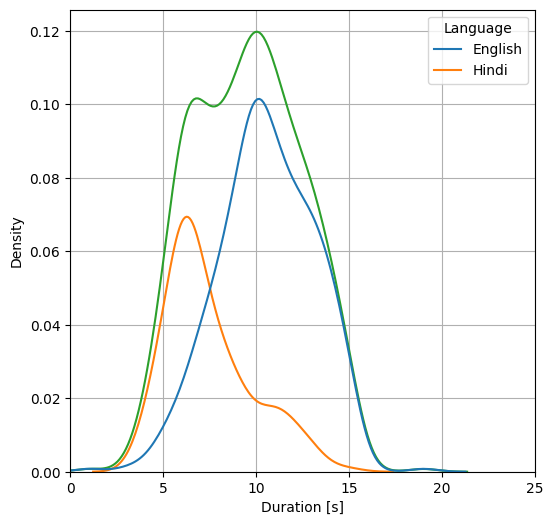

In [25]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata, x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata, x='Duration [s]', hue='Language' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [26]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration.pdf'))

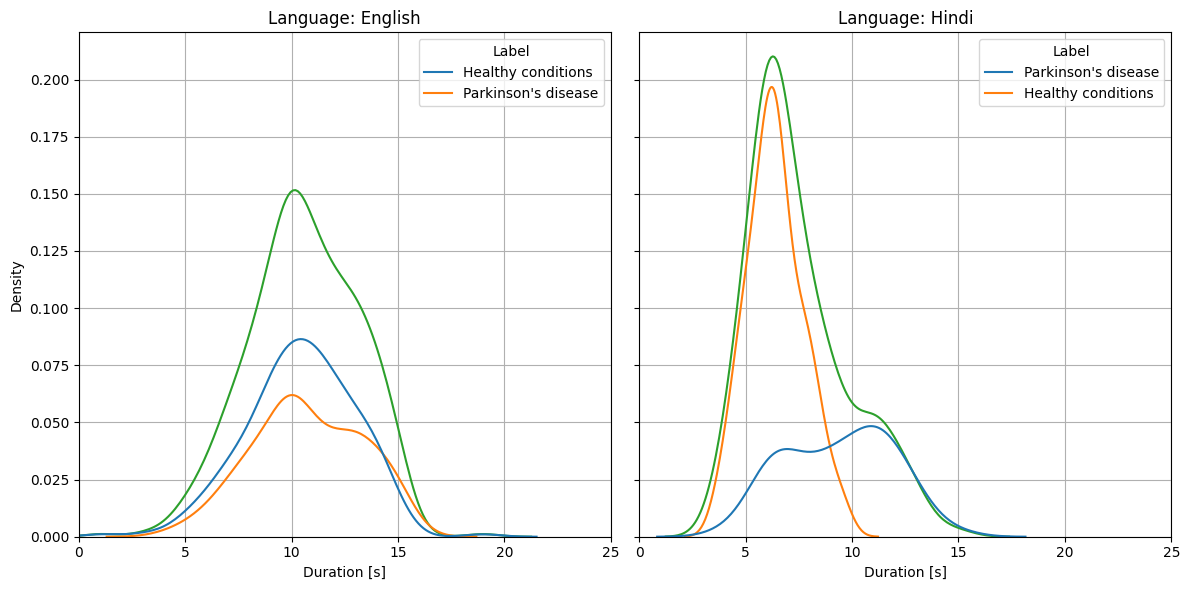

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

for i, (language) in enumerate(['English', 'Hindi']):
    sns.kdeplot(data=df_metadata[df_metadata['Language'] == language], x='Duration [s]', color='tab:green', ax=axes[i])
    sns.kdeplot(
        data=df_metadata[df_metadata['Language'] == language],
        x='Duration [s]',
        hue='Label',
        color=['tab:red', 'tab:blue'],
        ax=axes[i]
    )
    plt.xlabel('Duration [s]')
    axes[i].set_title(f'Language: {language}')
    axes[i].set_xlabel('Duration [s]')
    axes[i].grid()
    axes[i].set_xlim(0, 25)

plt.tight_layout()
plt.show()


In [28]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_lang.pdf'))

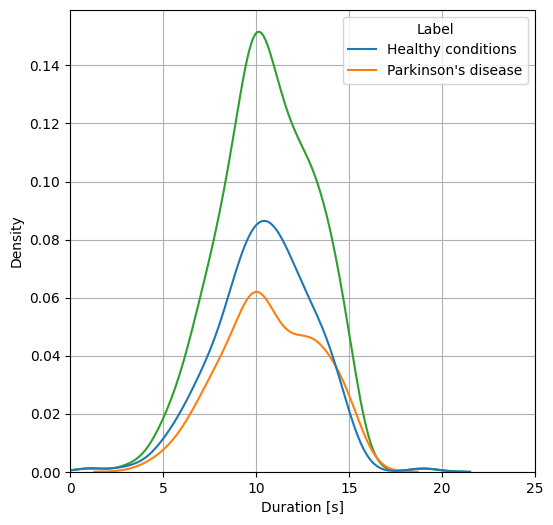

In [29]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'English'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:blue'])
plt.xlabel('Duration [s]')
plt.xlim(0, 25)
plt.grid()

plt.show()

In [30]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_en.pdf'))

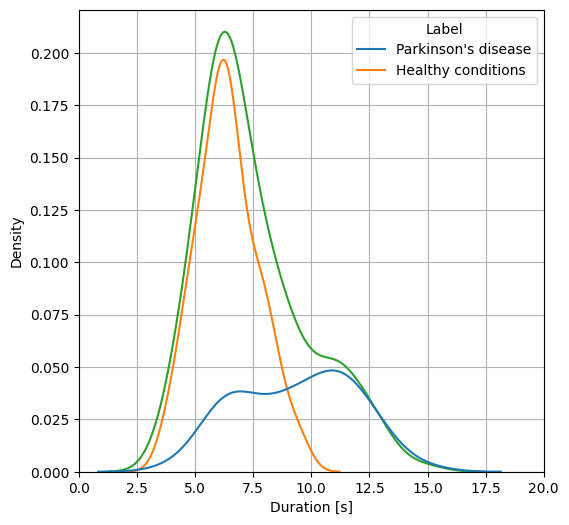

In [31]:
fig = plt.figure(figsize=(6, 6))

sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Hindi'], x='Duration [s]', color='tab:green')
sns.kdeplot(data=df_metadata[df_metadata['Language'] == 'Hindi'], x='Duration [s]', hue='Label' , color=['tab:red', 'tab:green'])
plt.xlabel('Duration [s]')
plt.xlim(0, 20)
plt.grid()

plt.show()

In [32]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'dist_duration_hi.pdf'))

Cumulative durations

In [33]:
print(f"Total time [s]:                        {datetime.timedelta(seconds=df_metadata['Duration [s]'].sum())}")
print(f"Healthy patients time [s]:             {datetime.timedelta(seconds=df_metadata[df_metadata['Label'] == 'Healthy conditions']['Duration [s]'].sum())}")
print(f"Parkinson's disease patients time [s]: {datetime.timedelta(seconds=df_metadata[df_metadata['Label'] != 'Healthy conditions']['Duration [s]'].sum())}")

Total time [s]:                        1:49:14.910000
Healthy patients time [s]:             1:00:57.787429
Parkinson's disease patients time [s]: 0:48:17.122571


In [34]:
for language in ['English', 'Hindi']:
    print(language)
    print(f"Total time [s]:                        {datetime.timedelta(seconds=df_metadata[df_metadata['Language'] == language]['Duration [s]'].sum())}")
    print(f"Healthy patients time [s]:             {datetime.timedelta(seconds=df_metadata[(df_metadata['Label'] == 'Healthy conditions') & (df_metadata['Language'] == language)]['Duration [s]'].sum())}")
    print(f"Parkinson's disease patients time [s]: {datetime.timedelta(seconds=df_metadata[(df_metadata['Label'] != 'Healthy conditions') & (df_metadata['Language'] == language)]['Duration [s]'].sum())}")
    print('\n')

English
Total time [s]:                        1:21:03.083333
Healthy patients time [s]:             0:45:25.171429
Parkinson's disease patients time [s]: 0:35:37.911905


Hindi
Total time [s]:                        0:28:11.826667
Healthy patients time [s]:             0:15:32.616000
Parkinson's disease patients time [s]: 0:12:39.210667




## Results
Load DataFrames with results

In [40]:
df_en_to_hi: pd.DataFrame = pd.read_csv(os.path.join(EN_TO_HI_EXPERIMENTS_DIR, 'scores.csv'))
df_en_to_hi = convert_results_df(df_en_to_hi)

In [41]:
df_hi_to_en = pd.read_csv(os.path.join(HI_TO_EN_EXPERIMENTS_DIR, 'scores.csv'))
df_hi_to_en = convert_results_df(df_hi_to_en)
df_hi_to_en.sample(10)

Input features Pooling approach              Domain adaptation  \
321                 VGGish       Flattening  CORrelation ALignment (CORAL)   
180                 VGGish     Avg. pooling                           None   
223                 VGGish     Avg. pooling  CORrelation ALignment (CORAL)   
342               SoundNet     Avg. pooling                           None   
329                 VGGish       Flattening  CORrelation ALignment (CORAL)   
179                 VGGish     Avg. pooling                           None   
358               SoundNet     Avg. pooling                           None   
166  Acoustic and Spectral       Flattening  CORrelation ALignment (CORAL)   
26   Acoustic and Spectral     Avg. pooling                           None   
439               SoundNet      Max pooling  CORrelation ALignment (CORAL)   

                     Data set                                   Metric  \
321  Source data (test split)                         Confusion matrix   
180  Source data (test split)  Threshold (from precision-recall curve)   
223               Target data                         Confusion matrix   
342  Source data (test split)                                  ROC AUC   
329               Target data                     False positives rate   
179  Source data (test split)                             Recall score   
358               Target data                       True postives rate   
166               Target data  Threshold (from precision-recall curve)   
26                Target data  Threshold (from precision-recall curve)   
439               Target data                              Specificity   

                                                 Value  
321                                [[7, 16], [19, 11]]  
180  [0.8281929873262445, 0.08755083535524433, 0.11...  
223                                   [[6, 2], [9, 9]]  
342                                           0.815026  
329  [0.8317232100019775, 0.02827055586085858, 0.27...  
179  [0.8585756519399969, 0.9397402871526592, 0.723...  
358  [0.982277268863604, 0.1813911806952686, 0.8001...  
166  [0.5254069471225834, 0.3622717896206388, 0.131...  
26   [0.24313313389266067, 0.5663093294381006, 0.82...  
439                                           0.846523

### Detection in English

In [54]:
df = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_hi['Data set'] == DATA_MAPPING['src']) & df_en_to_hi['Metric'].isin(METRICS)]
print(df)

            Input features Pooling approach Domain adaptation  \
0    Acoustic and Spectral     Avg. pooling              None   
1    Acoustic and Spectral     Avg. pooling              None   
2    Acoustic and Spectral     Avg. pooling              None   
3    Acoustic and Spectral     Avg. pooling              None   
5    Acoustic and Spectral     Avg. pooling              None   
..                     ...              ...               ...   
617            Wav2Vec 2.0       Flattening              None   
618            Wav2Vec 2.0       Flattening              None   
619            Wav2Vec 2.0       Flattening              None   
621            Wav2Vec 2.0       Flattening              None   
622            Wav2Vec 2.0       Flattening              None   

                     Data set       Metric     Value  
0    Source data (test split)     Accuracy  0.856887  
1    Source data (test split)    Precision  0.341036  
2    Source data (test split)       Recall  0.128991  

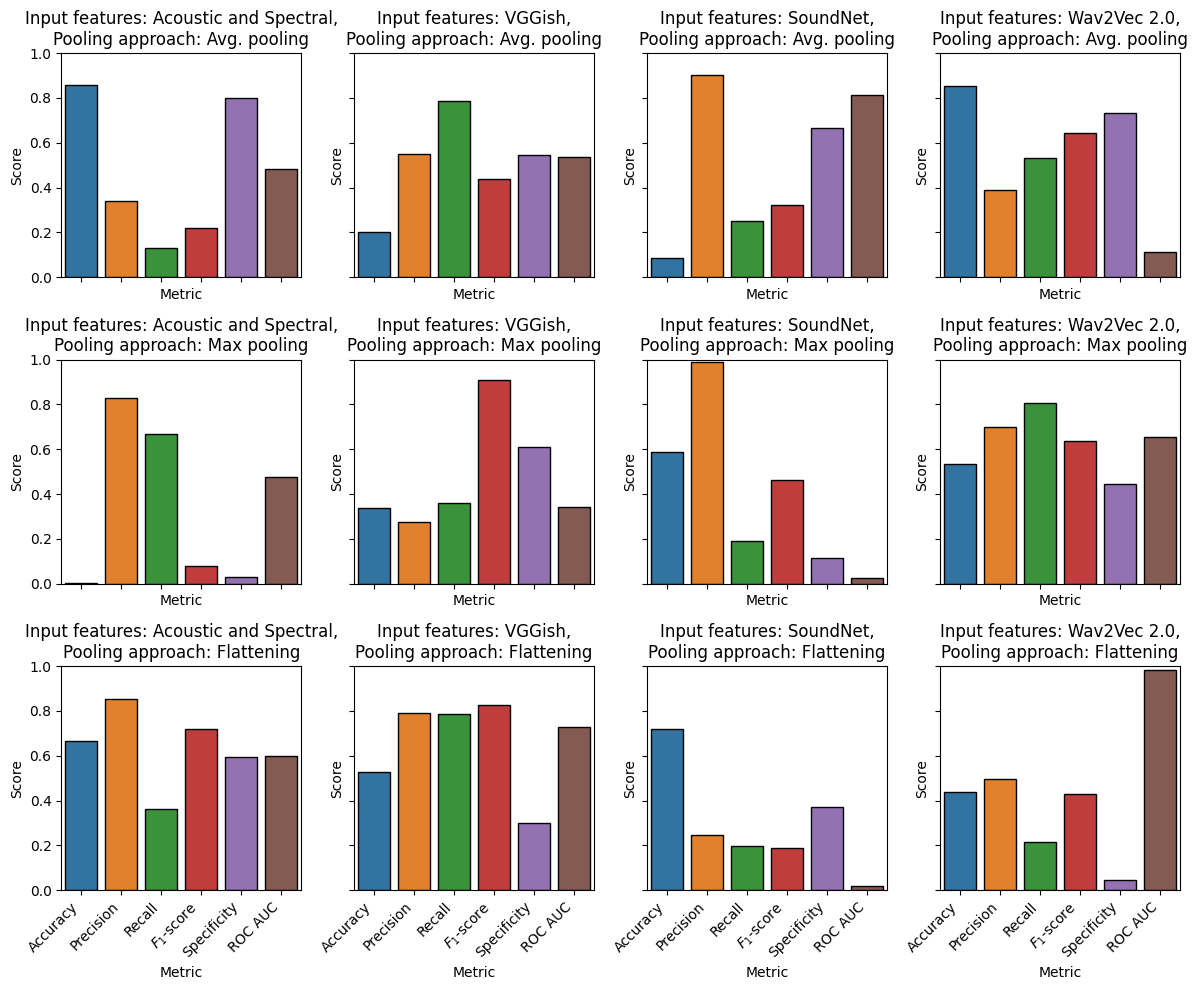

In [55]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        sns.barplot(
            data=df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS)
        )
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [56]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_cls_results.pdf'))

#### ROC curve

In [57]:
df = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_hi['Data set'] == DATA_MAPPING['src']) & (df_en_to_hi['Metric'].isin(ROC))
]
df.sample(10)

Input features Pooling approach Domain adaptation  \
288                 VGGish       Flattening              None   
400               SoundNet      Max pooling              None   
65   Acoustic and Spectral      Max pooling              None   
457               SoundNet       Flattening              None   
345               SoundNet     Avg. pooling              None   
625            Wav2Vec 2.0       Flattening              None   
177                 VGGish     Avg. pooling              None   
175                 VGGish     Avg. pooling              None   
119  Acoustic and Spectral       Flattening              None   
287                 VGGish       Flattening              None   

                     Data set                      Metric  \
288  Source data (test split)          True postives rate   
400  Source data (test split)          True postives rate   
65   Source data (test split)  Threshold (from ROC curve)   
457  Source data (test split)  Threshold (from ROC curve)   
345  Source data (test split)  Threshold (from ROC curve)   
625  Source data (test split)  Threshold (from ROC curve)   
177  Source data (test split)  Threshold (from ROC curve)   
175  Source data (test split)        False positives rate   
119  Source data (test split)        False positives rate   
287  Source data (test split)        False positives rate   

                                                 Value  
288  [0.4278447971958327, 0.12532415363927196, 0.80...  
400  [0.066172237184415, 0.40430764796304997, 0.882...  
65   [0.3060826323625573, 0.2486045103976522, 0.017...  
457  [0.6317664808281216, 0.055332384209733965, 0.5...  
345  [0.5752931653884288, 0.9948293764565153, 0.070...  
625  [0.5931054002333409, 0.7625411344197459, 0.808...  
177  [0.4336744614087813, 0.5281112865101955, 0.606...  
175  [0.5383279262763604, 0.17121315299487194, 0.32...  
119  [0.6688107617822278, 0.8286881786396217, 0.117...  
287  [0.7956327481579636, 0.4148186860197717, 0.453...

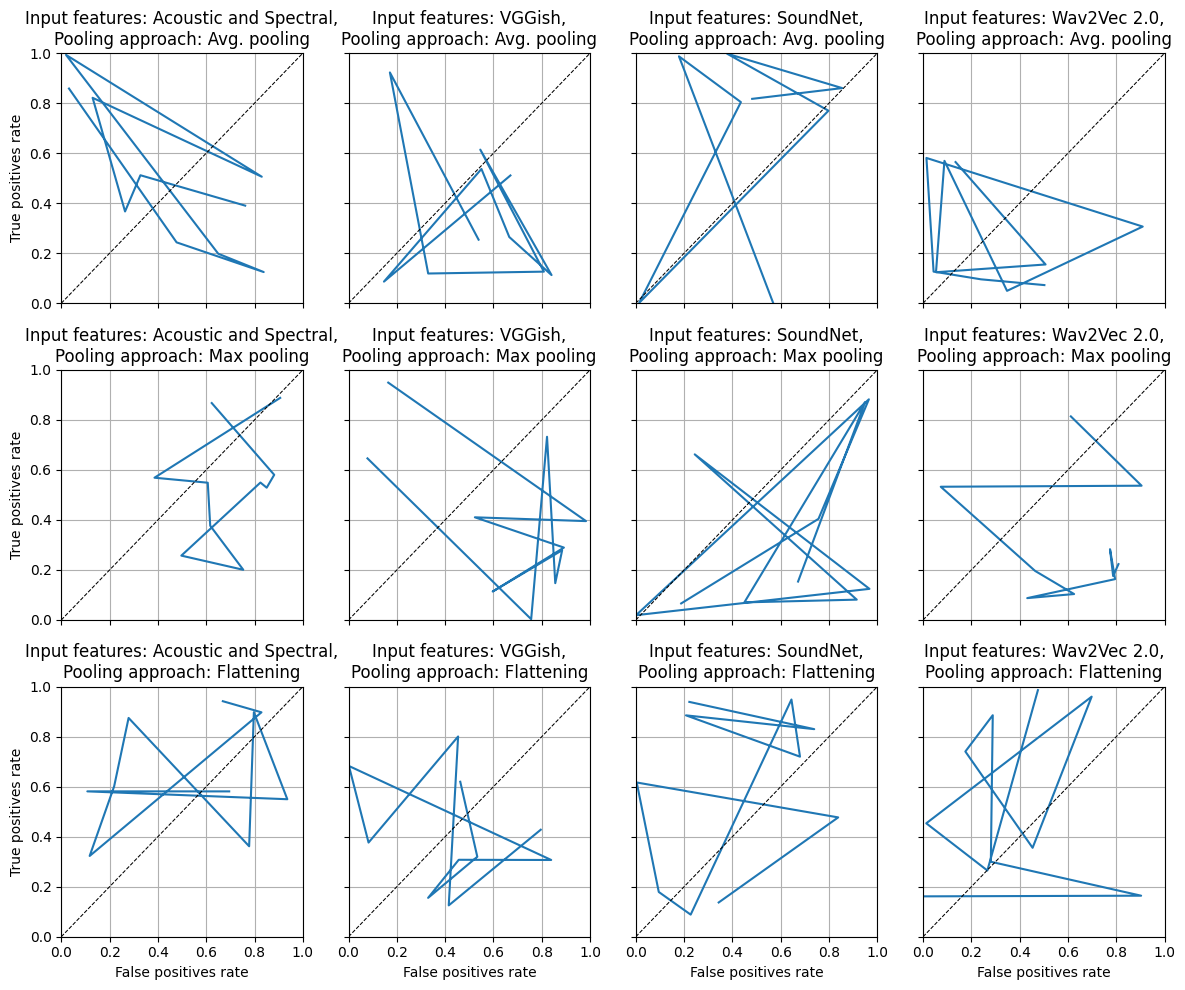

In [58]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [60]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_roc_curve.pdf'))

#### Precision-recall curve

In [61]:
df = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_hi['Data set'] == DATA_MAPPING['src']) & (df_en_to_hi['Metric'].isin(PRC_REC))
]
df.sample(10)

Input features Pooling approach Domain adaptation  \
124  Acoustic and Spectral       Flattening              None   
123  Acoustic and Spectral       Flattening              None   
572            Wav2Vec 2.0      Max pooling              None   
178                 VGGish     Avg. pooling              None   
458               SoundNet       Flattening              None   
234                 VGGish      Max pooling              None   
459               SoundNet       Flattening              None   
347               SoundNet     Avg. pooling              None   
10   Acoustic and Spectral     Avg. pooling              None   
626            Wav2Vec 2.0       Flattening              None   

                     Data set                                   Metric  \
124  Source data (test split)  Threshold (from precision-recall curve)   
123  Source data (test split)                             Recall score   
572  Source data (test split)  Threshold (from precision-recall curve)   
178  Source data (test split)                          Precision score   
458  Source data (test split)                          Precision score   
234  Source data (test split)                          Precision score   
459  Source data (test split)                             Recall score   
347  Source data (test split)                             Recall score   
10   Source data (test split)                          Precision score   
626  Source data (test split)                          Precision score   

                                                 Value  
124  [0.940558034651765, 0.2832881073360186, 0.1115...  
123  [0.7427016382746776, 0.6507205099357959, 0.431...  
572  [0.18445965282290055, 0.002325757941810891, 0....  
178  [0.5974461960761099, 0.037744172484257765, 0.3...  
458  [0.15582086516272453, 0.8506588820902322, 0.92...  
234  [0.22726813284593206, 0.3907261813342021, 0.37...  
459  [0.2756713533538907, 0.013342002183380441, 0.8...  
347  [0.8028881034027731, 0.1950359197988233, 0.158...  
10   [0.7384271516573574, 0.8733062092514502, 0.057...  
626  [0.07187659745665076, 0.08764593011467336, 0.7...

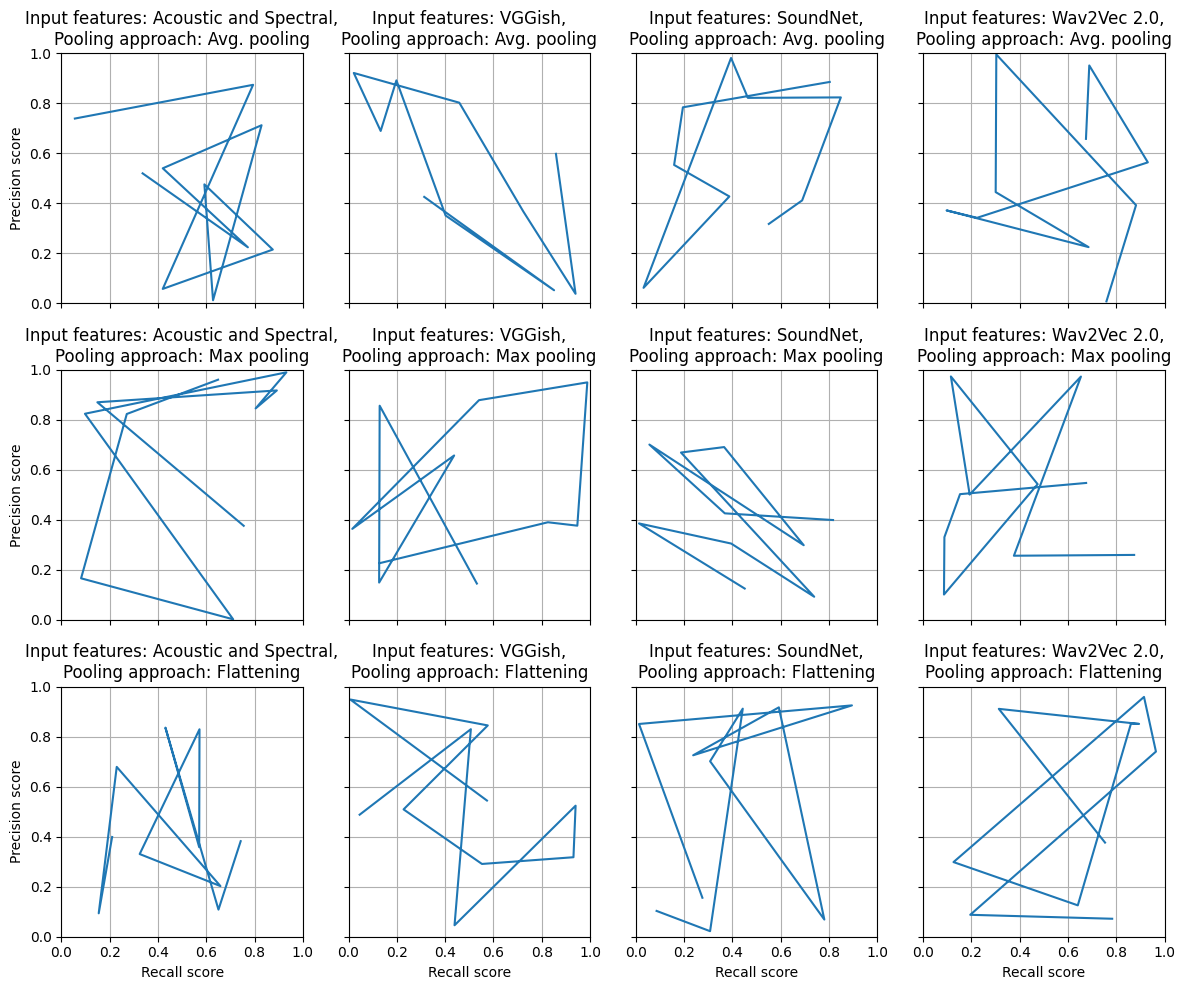

In [62]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_pr_curve.pdf'))

#### Confusion matrix

In [63]:
df = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_hi['Data set'] == DATA_MAPPING['src']) & (df_en_to_hi['Metric'].isin(CONF_MAT))
]
df.sample(10)

Input features Pooling approach Domain adaptation  \
13   Acoustic and Spectral     Avg. pooling              None   
125  Acoustic and Spectral       Flattening              None   
69   Acoustic and Spectral      Max pooling              None   
629            Wav2Vec 2.0       Flattening              None   
573            Wav2Vec 2.0      Max pooling              None   
461               SoundNet       Flattening              None   
405               SoundNet      Max pooling              None   
293                 VGGish       Flattening              None   
349               SoundNet     Avg. pooling              None   
237                 VGGish      Max pooling              None   

                     Data set            Metric                Value  
13   Source data (test split)  Confusion matrix  [[11, 16], [8, 17]]  
125  Source data (test split)  Confusion matrix   [[1, 17], [3, 14]]  
69   Source data (test split)  Confusion matrix    [[18, 6], [5, 8]]  
629  Source data (test split)  Confusion matrix   [[16, 3], [18, 9]]  
573  Source data (test split)  Confusion matrix   [[16, 3], [2, 19]]  
461  Source data (test split)  Confusion matrix    [[10, 8], [5, 7]]  
405  Source data (test split)  Confusion matrix   [[6, 11], [1, 14]]  
293  Source data (test split)  Confusion matrix    [[1, 18], [0, 5]]  
349  Source data (test split)  Confusion matrix  [[15, 15], [19, 4]]  
237  Source data (test split)  Confusion matrix   [[2, 13], [5, 10]]

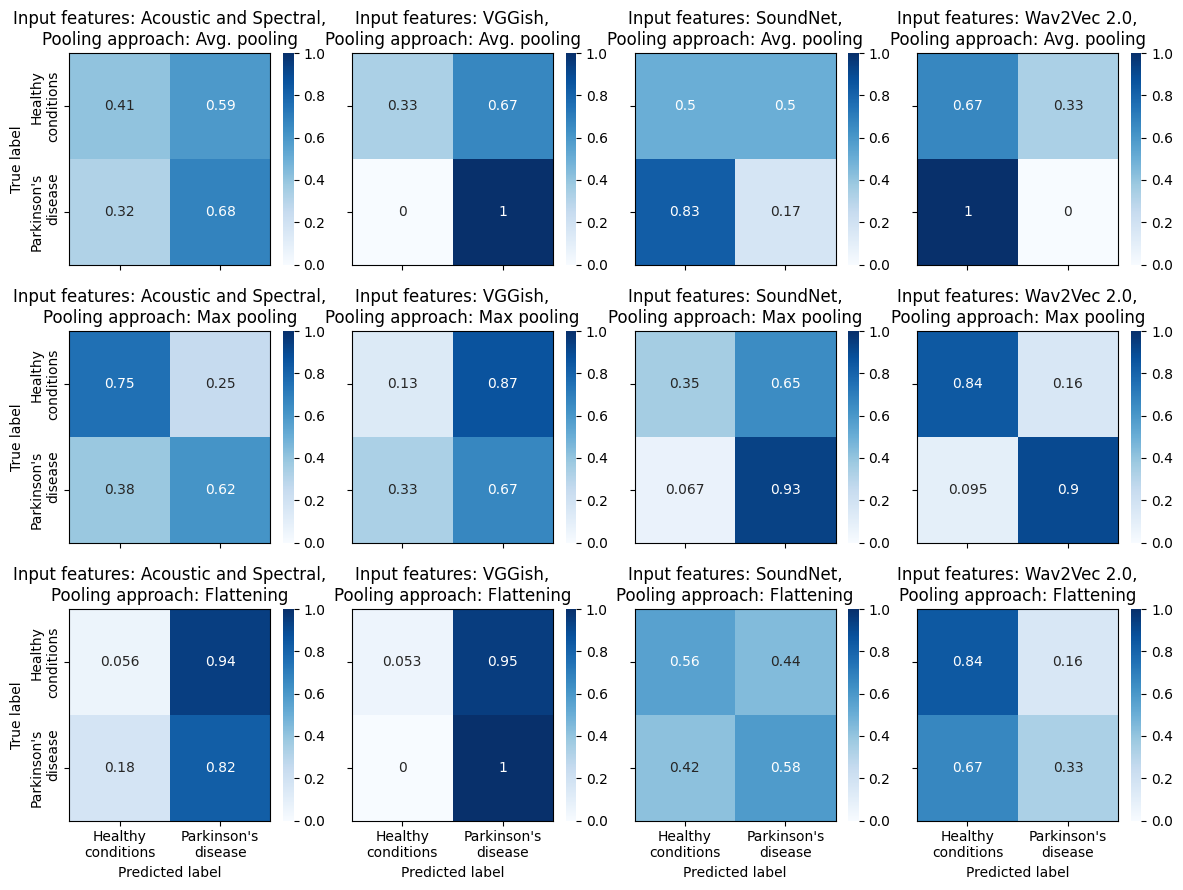

In [64]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [65]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_cm.pdf'))

### Transferring from English to Hindi

In [155]:
df_all = df_en_to_hi[
    (df_en_to_hi['Data set'] == DATA_MAPPING['tgt']) & (df_en_to_hi['Metric'].isin(METRICS))]
print(df_no_ad)

            Input features Pooling approach Domain adaptation     Data set  \
27   Acoustic and Spectral     Avg. pooling              None  Target data   
83   Acoustic and Spectral      Max pooling              None  Target data   
139  Acoustic and Spectral       Flattening              None  Target data   
195                 VGGish     Avg. pooling              None  Target data   
251                 VGGish      Max pooling              None  Target data   
307                 VGGish       Flattening              None  Target data   
363               SoundNet     Avg. pooling              None  Target data   
419               SoundNet      Max pooling              None  Target data   
475               SoundNet       Flattening              None  Target data   
531            Wav2Vec 2.0     Avg. pooling              None  Target data   
587            Wav2Vec 2.0      Max pooling              None  Target data   
643            Wav2Vec 2.0       Flattening              None  T

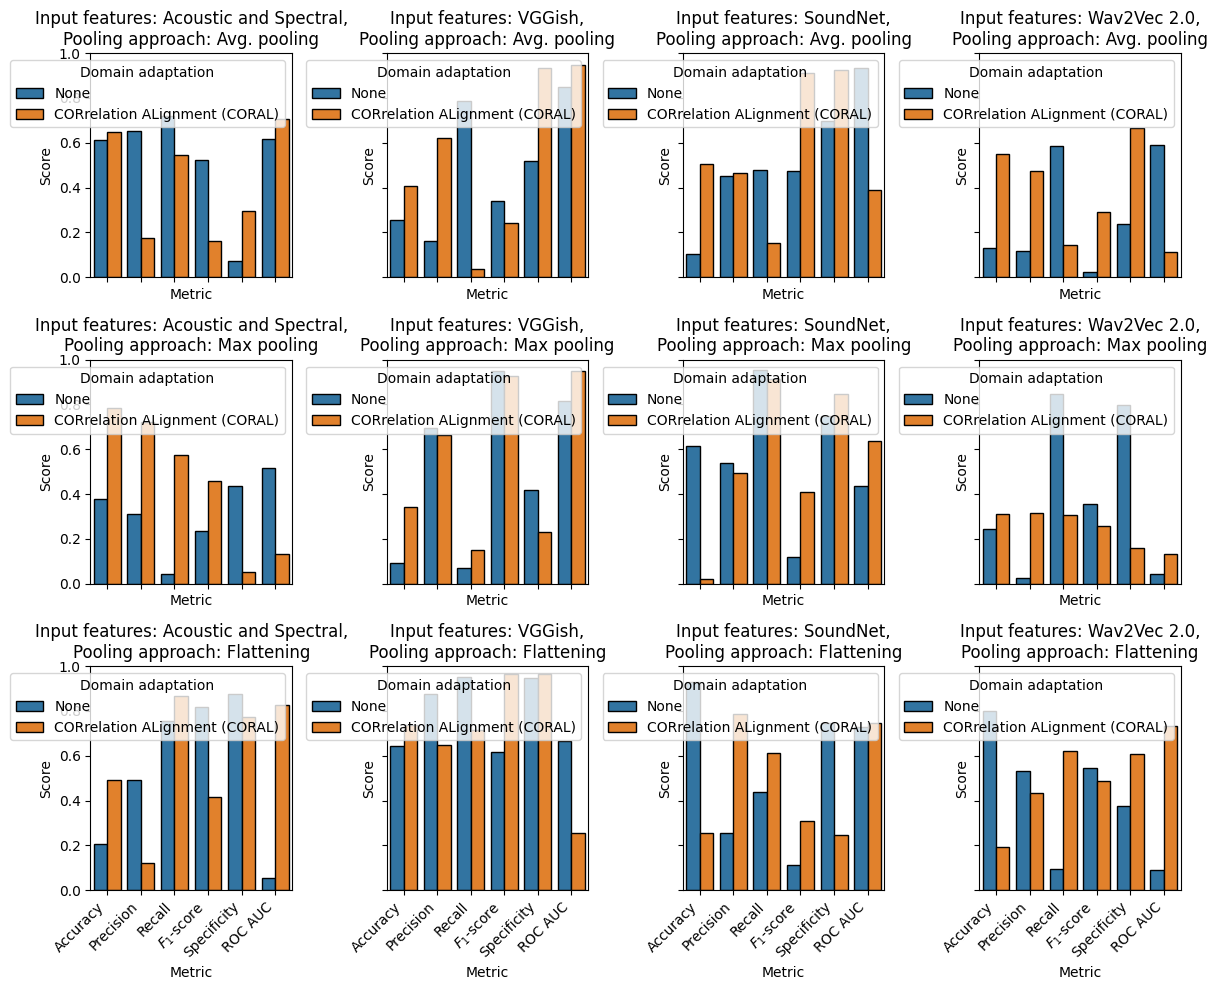

In [98]:
fig, axes = plt.subplots(
        nrows=len(df_all['Pooling approach'].unique()),
        ncols=len(df_all['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )



for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        
        sns.barplot(
            data=df_all[(df_all['Input features'] == feature) & (df_all['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS),
            hue='Domain adaptation'
        )
       
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [96]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_hi_results.pdf'))

### ROC curve

In [99]:
df = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_en_to_hi['Data set'] == DATA_MAPPING['tgt']) & df_en_to_hi['Metric'].isin(ROC)]
df_no_ad = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_hi['Data set'] == DATA_MAPPING['tgt']) & df_en_to_hi['Metric'].isin(ROC)]
print(df_no_ad)

            Input features Pooling approach Domain adaptation     Data set  \
21   Acoustic and Spectral     Avg. pooling              None  Target data   
22   Acoustic and Spectral     Avg. pooling              None  Target data   
23   Acoustic and Spectral     Avg. pooling              None  Target data   
77   Acoustic and Spectral      Max pooling              None  Target data   
78   Acoustic and Spectral      Max pooling              None  Target data   
79   Acoustic and Spectral      Max pooling              None  Target data   
133  Acoustic and Spectral       Flattening              None  Target data   
134  Acoustic and Spectral       Flattening              None  Target data   
135  Acoustic and Spectral       Flattening              None  Target data   
189                 VGGish     Avg. pooling              None  Target data   
190                 VGGish     Avg. pooling              None  Target data   
191                 VGGish     Avg. pooling              None  T

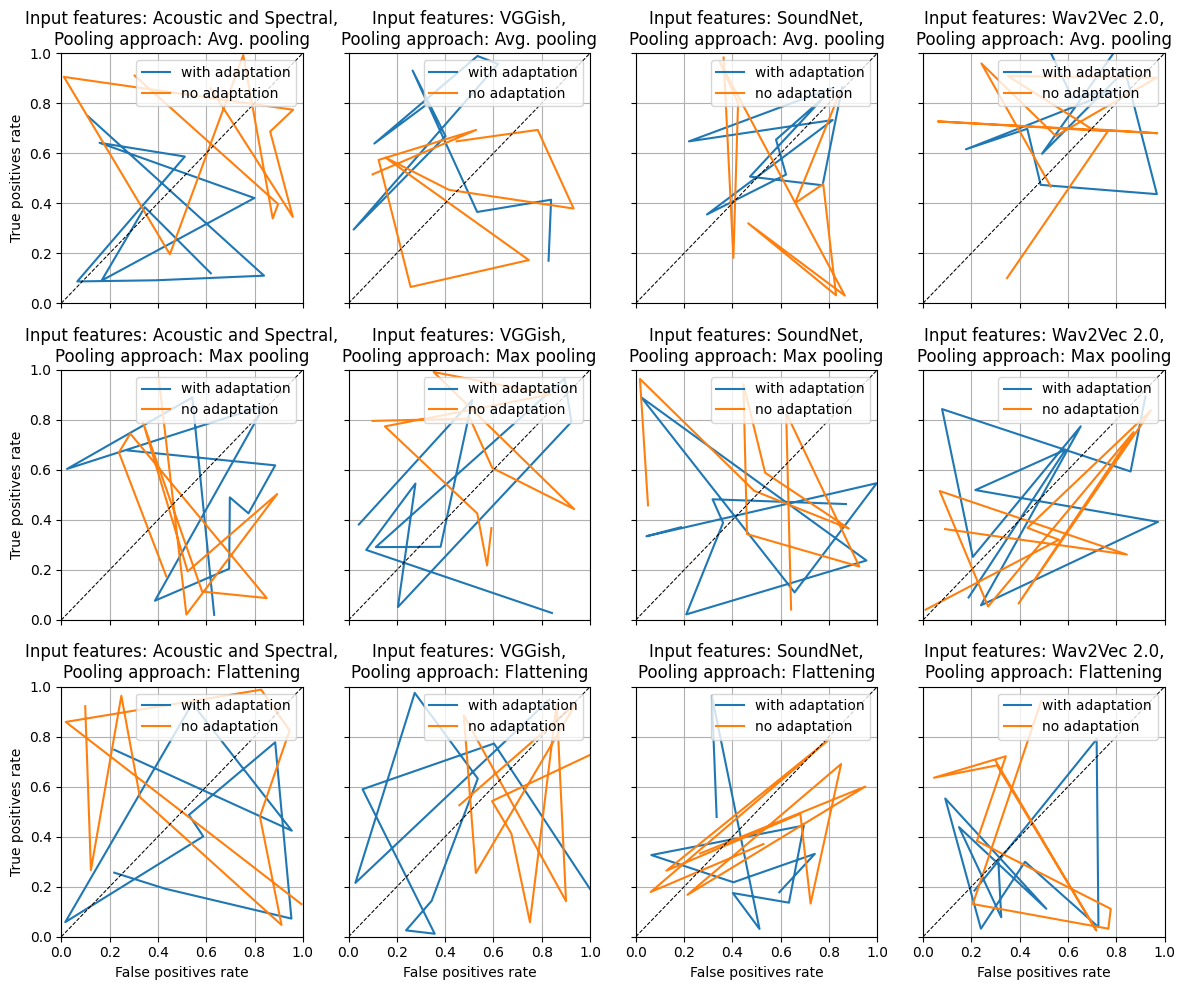

In [119]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'False positives rate')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'True postives rate')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label = "with adaptation")
        axes[i][j].plot(x_1, y_1, label = "no adaptation")
        axes[i][j].legend(loc='upper right')
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [120]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_hiroc_curve.pdf'))

#### Precision-recall curve

In [122]:
df = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_en_to_hi['Data set'] == DATA_MAPPING['tgt']) & df_en_to_hi['Metric'].isin(PRC_REC)]
df_no_ad = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_hi['Data set'] == DATA_MAPPING['tgt']) & df_en_to_hi['Metric'].isin(PRC_REC)]
df_all = df_en_to_hi[
    (df_en_to_hi['Data set'] == DATA_MAPPING['tgt']) & (df_en_to_hi['Metric'].isin(PRC_REC))]
print(df_no_ad)

            Input features Pooling approach Domain adaptation     Data set  \
24   Acoustic and Spectral     Avg. pooling              None  Target data   
25   Acoustic and Spectral     Avg. pooling              None  Target data   
26   Acoustic and Spectral     Avg. pooling              None  Target data   
80   Acoustic and Spectral      Max pooling              None  Target data   
81   Acoustic and Spectral      Max pooling              None  Target data   
82   Acoustic and Spectral      Max pooling              None  Target data   
136  Acoustic and Spectral       Flattening              None  Target data   
137  Acoustic and Spectral       Flattening              None  Target data   
138  Acoustic and Spectral       Flattening              None  Target data   
192                 VGGish     Avg. pooling              None  Target data   
193                 VGGish     Avg. pooling              None  Target data   
194                 VGGish     Avg. pooling              None  T

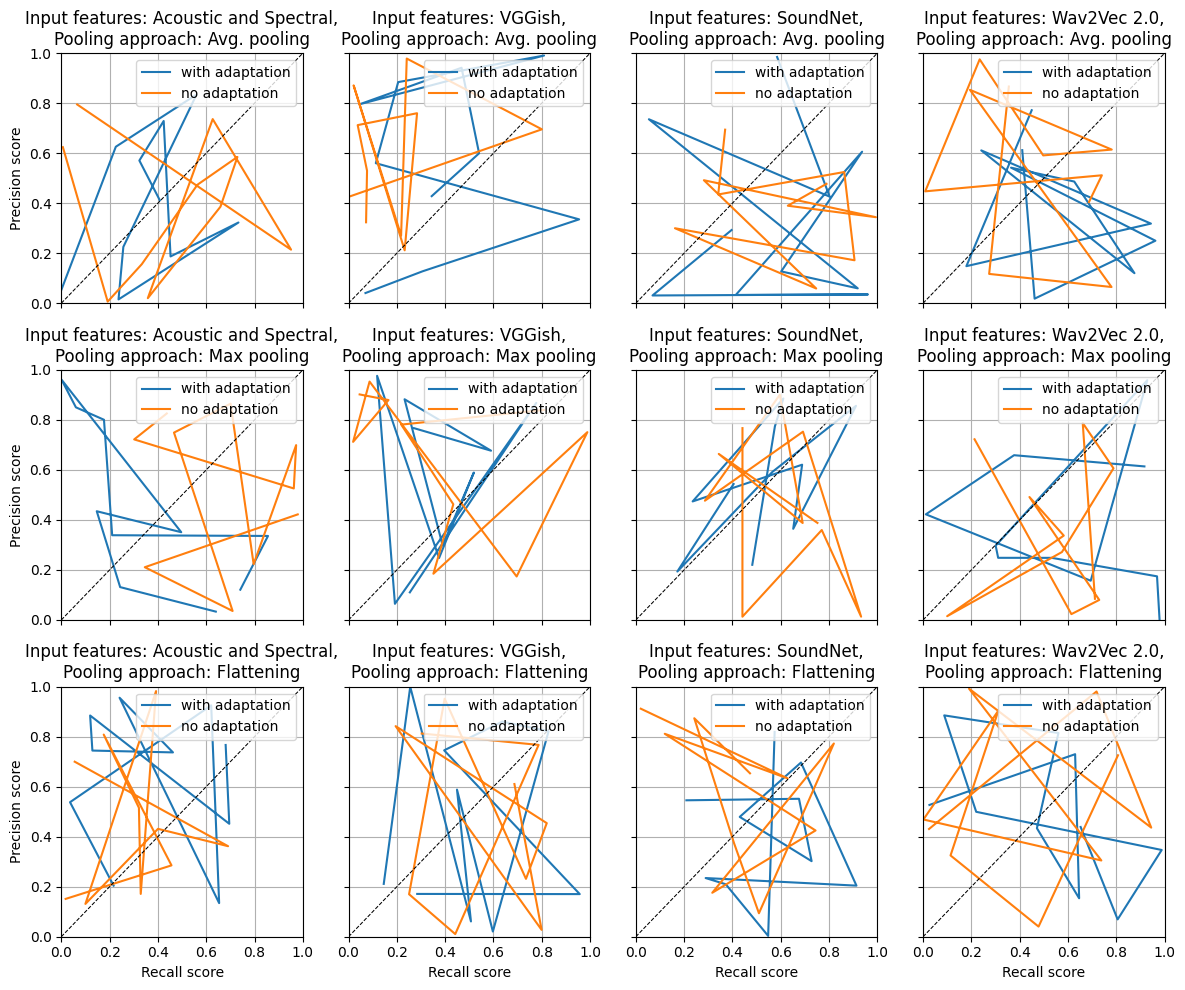

In [123]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Recall score')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Precision score')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label = "with adaptation")
        axes[i][j].plot(x_1, y_1, label = "no adaptation")
        axes[i][j].legend(loc='upper right')
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [124]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_hipr_curve.pdf'))

#### Confusion matrix

In [126]:
df = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_en_to_hi['Data set'] == DATA_MAPPING['tgt']) & df_en_to_hi['Metric'].isin(CONF_MAT)]
df_no_ad = df_en_to_hi[
    (df_en_to_hi['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_en_to_hi['Data set'] == DATA_MAPPING['tgt']) & df_en_to_hi['Metric'].isin(CONF_MAT)]
df_all = df_en_to_hi[
    (df_en_to_hi['Data set'] == DATA_MAPPING['tgt']) & (df_en_to_hi['Metric'].isin(CONF_MAT))]
print(df_no_ad)

            Input features Pooling approach Domain adaptation     Data set  \
27   Acoustic and Spectral     Avg. pooling              None  Target data   
83   Acoustic and Spectral      Max pooling              None  Target data   
139  Acoustic and Spectral       Flattening              None  Target data   
195                 VGGish     Avg. pooling              None  Target data   
251                 VGGish      Max pooling              None  Target data   
307                 VGGish       Flattening              None  Target data   
363               SoundNet     Avg. pooling              None  Target data   
419               SoundNet      Max pooling              None  Target data   
475               SoundNet       Flattening              None  Target data   
531            Wav2Vec 2.0     Avg. pooling              None  Target data   
587            Wav2Vec 2.0      Max pooling              None  Target data   
643            Wav2Vec 2.0       Flattening              None  T

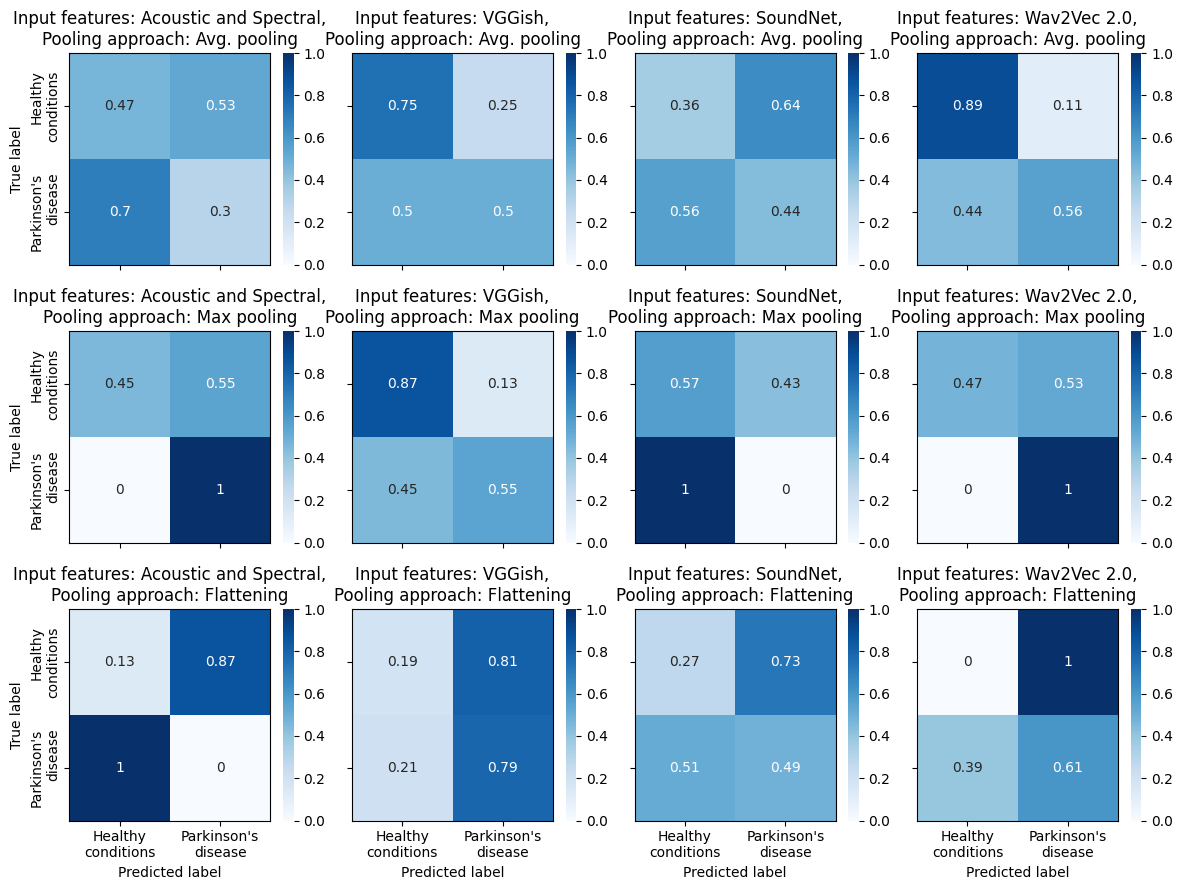

In [127]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [128]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_hi_with_adpt_cm.pdf'))

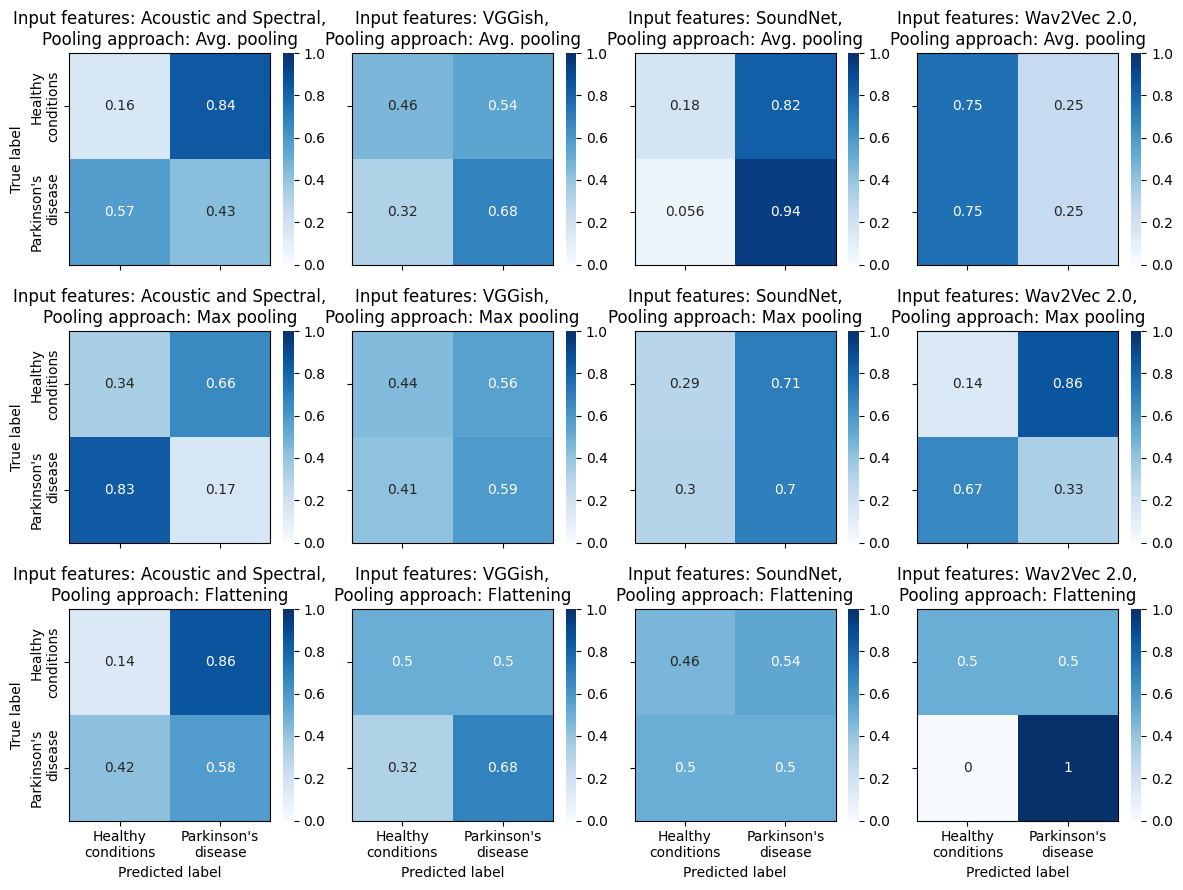

In [133]:
fig, axes = plt.subplots(
        nrows=len(df_no_ad['Pooling approach'].unique()),
        ncols=len(df_no_ad['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [134]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'en_to_hi_no_adpt_cm.pdf'))

### Detection in Hindi

In [45]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['src']) & df_hi_to_en['Metric'].isin(METRICS)]
print(df)

            Input features Pooling approach Domain adaptation  \
0    Acoustic and Spectral     Avg. pooling              None   
1    Acoustic and Spectral     Avg. pooling              None   
2    Acoustic and Spectral     Avg. pooling              None   
3    Acoustic and Spectral     Avg. pooling              None   
5    Acoustic and Spectral     Avg. pooling              None   
..                     ...              ...               ...   
617            Wav2Vec 2.0       Flattening              None   
618            Wav2Vec 2.0       Flattening              None   
619            Wav2Vec 2.0       Flattening              None   
621            Wav2Vec 2.0       Flattening              None   
622            Wav2Vec 2.0       Flattening              None   

                     Data set       Metric     Value  
0    Source data (test split)     Accuracy  0.856887  
1    Source data (test split)    Precision  0.341036  
2    Source data (test split)       Recall  0.128991  

#### Metrics comparison

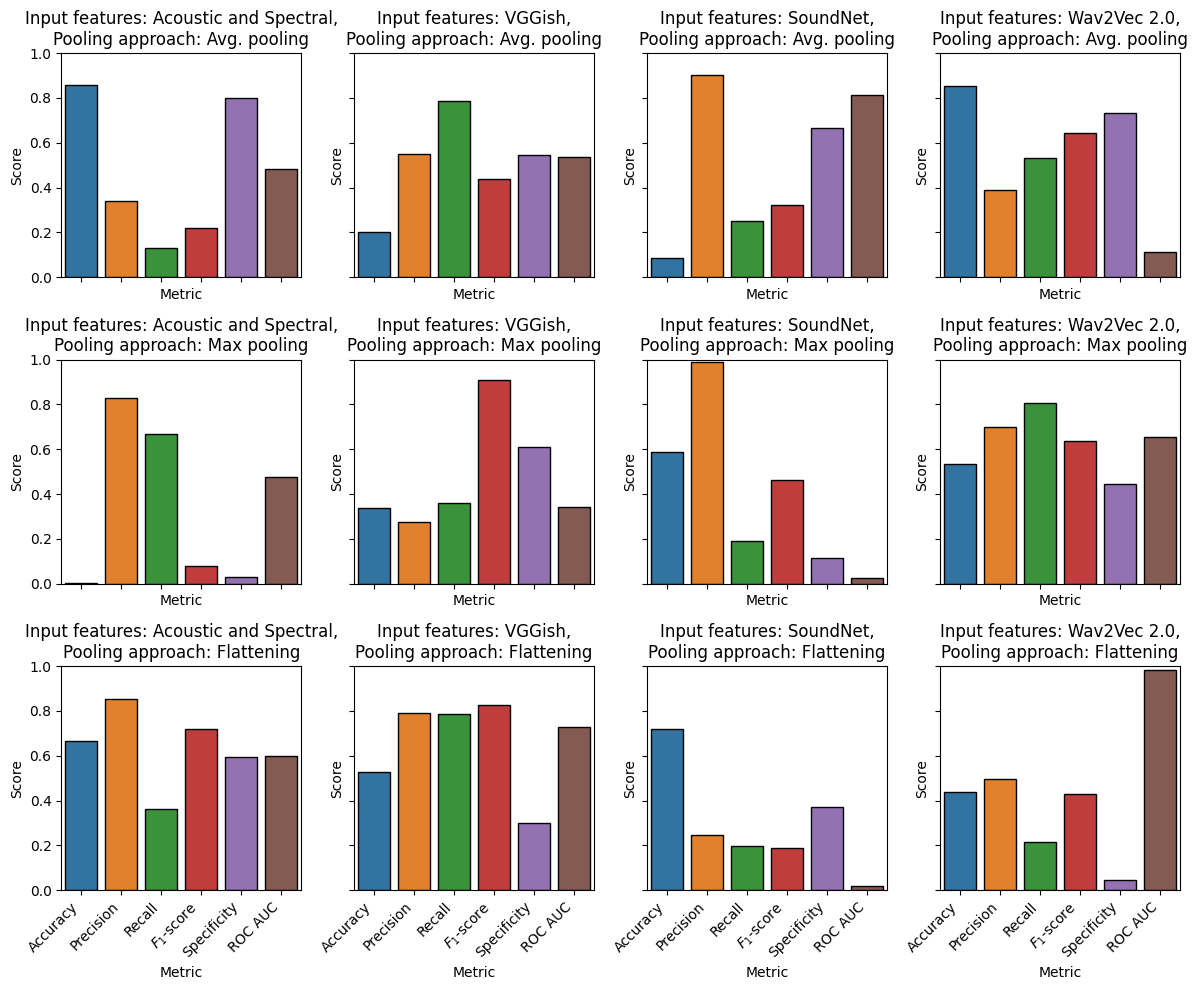

In [46]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        sns.barplot(
            data=df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS)
        )
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [47]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_cls_results.pdf'))

#### ROC curve

In [48]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['src']) & (df_hi_to_en['Metric'].isin(ROC))
]
df.sample(10)

Input features Pooling approach Domain adaptation  \
9    Acoustic and Spectral     Avg. pooling              None   
65   Acoustic and Spectral      Max pooling              None   
345               SoundNet     Avg. pooling              None   
177                 VGGish     Avg. pooling              None   
456               SoundNet       Flattening              None   
625            Wav2Vec 2.0       Flattening              None   
175                 VGGish     Avg. pooling              None   
119  Acoustic and Spectral       Flattening              None   
343               SoundNet     Avg. pooling              None   
513            Wav2Vec 2.0     Avg. pooling              None   

                     Data set                      Metric  \
9    Source data (test split)  Threshold (from ROC curve)   
65   Source data (test split)  Threshold (from ROC curve)   
345  Source data (test split)  Threshold (from ROC curve)   
177  Source data (test split)  Threshold (from ROC curve)   
456  Source data (test split)          True postives rate   
625  Source data (test split)  Threshold (from ROC curve)   
175  Source data (test split)        False positives rate   
119  Source data (test split)        False positives rate   
343  Source data (test split)        False positives rate   
513  Source data (test split)  Threshold (from ROC curve)   

                                                 Value  
9    [0.5294763084529415, 0.884811481950711, 0.6320...  
65   [0.3060826323625573, 0.2486045103976522, 0.017...  
345  [0.5752931653884288, 0.9948293764565153, 0.070...  
177  [0.4336744614087813, 0.5281112865101955, 0.606...  
456  [0.9388524591496124, 0.8299456532589105, 0.885...  
625  [0.5931054002333409, 0.7625411344197459, 0.808...  
175  [0.5383279262763604, 0.17121315299487194, 0.32...  
119  [0.6688107617822278, 0.8286881786396217, 0.117...  
343  [0.5689736881000864, 0.19808823417019406, 0.17...  
513  [0.7925078876039461, 0.22066545543681948, 0.89...

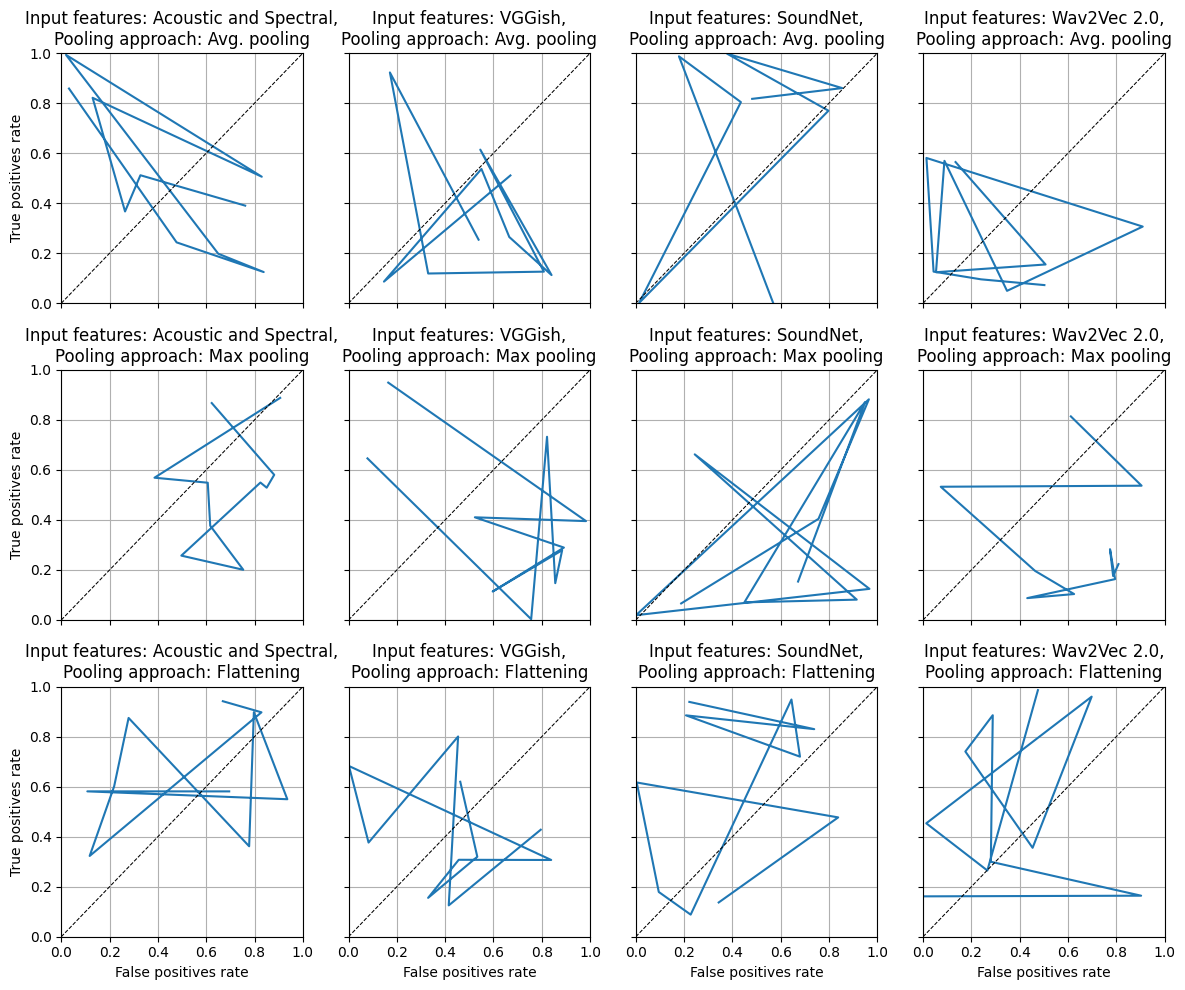

In [49]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_roc_curve.pdf'))

#### Precision-recall curve

In [50]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['src']) & (df_hi_to_en['Metric'].isin(PRC_REC))
]
df.sample(10)

Input features Pooling approach Domain adaptation  \
459               SoundNet       Flattening              None   
404               SoundNet      Max pooling              None   
626            Wav2Vec 2.0       Flattening              None   
235                 VGGish      Max pooling              None   
627            Wav2Vec 2.0       Flattening              None   
347               SoundNet     Avg. pooling              None   
348               SoundNet     Avg. pooling              None   
572            Wav2Vec 2.0      Max pooling              None   
403               SoundNet      Max pooling              None   
11   Acoustic and Spectral     Avg. pooling              None   

                     Data set                                   Metric  \
459  Source data (test split)                             Recall score   
404  Source data (test split)  Threshold (from precision-recall curve)   
626  Source data (test split)                          Precision score   
235  Source data (test split)                             Recall score   
627  Source data (test split)                             Recall score   
347  Source data (test split)                             Recall score   
348  Source data (test split)  Threshold (from precision-recall curve)   
572  Source data (test split)  Threshold (from precision-recall curve)   
403  Source data (test split)                             Recall score   
11   Source data (test split)                             Recall score   

                                                 Value  
459  [0.2756713533538907, 0.013342002183380441, 0.8...  
404  [0.9737656063916668, 0.8355289025887799, 0.083...  
626  [0.07187659745665076, 0.08764593011467336, 0.7...  
235  [0.12922783267077842, 0.8253223960391233, 0.94...  
627  [0.7828747825816094, 0.19532040615781399, 0.96...  
347  [0.8028881034027731, 0.1950359197988233, 0.158...  
348  [0.411010096130919, 0.09597177795118594, 0.579...  
572  [0.18445965282290055, 0.002325757941810891, 0....  
403  [0.8164875802260365, 0.368533615677051, 0.0562...  
11   [0.05619148160430898, 0.7940211433987063, 0.42...

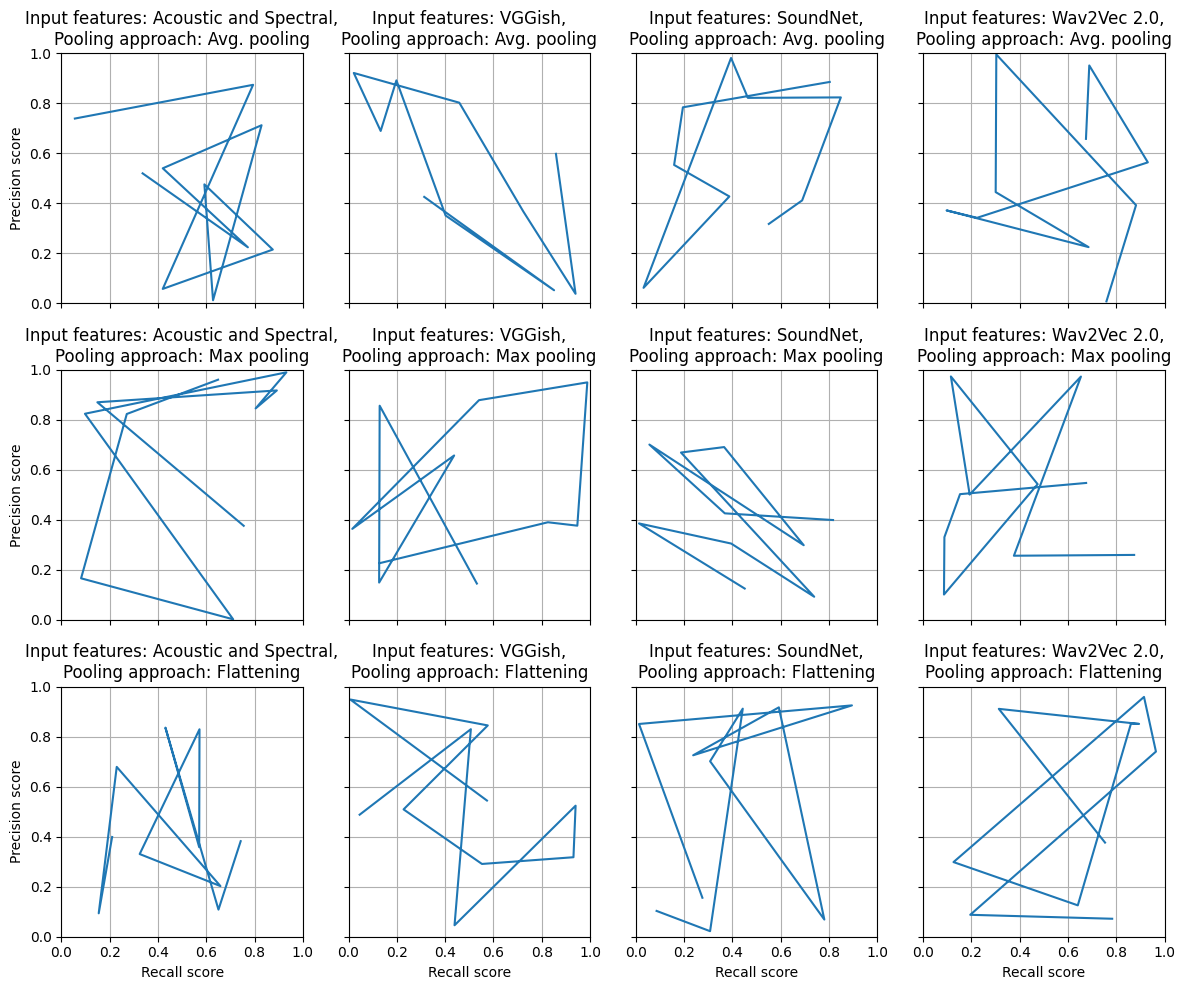

In [51]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        axes[i][j].plot(x, y)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()
        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_pr_curve.pdf'))

#### Confusion matrix

In [52]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['src']) & (df_hi_to_en['Metric'].isin(CONF_MAT))
]
df.sample(10)

Input features Pooling approach Domain adaptation  \
349               SoundNet     Avg. pooling              None   
517            Wav2Vec 2.0     Avg. pooling              None   
125  Acoustic and Spectral       Flattening              None   
13   Acoustic and Spectral     Avg. pooling              None   
69   Acoustic and Spectral      Max pooling              None   
181                 VGGish     Avg. pooling              None   
629            Wav2Vec 2.0       Flattening              None   
405               SoundNet      Max pooling              None   
461               SoundNet       Flattening              None   
237                 VGGish      Max pooling              None   

                     Data set            Metric                Value  
349  Source data (test split)  Confusion matrix  [[15, 15], [19, 4]]  
517  Source data (test split)  Confusion matrix   [[14, 7], [15, 0]]  
125  Source data (test split)  Confusion matrix   [[1, 17], [3, 14]]  
13   Source data (test split)  Confusion matrix  [[11, 16], [8, 17]]  
69   Source data (test split)  Confusion matrix    [[18, 6], [5, 8]]  
181  Source data (test split)  Confusion matrix    [[2, 4], [0, 16]]  
629  Source data (test split)  Confusion matrix   [[16, 3], [18, 9]]  
405  Source data (test split)  Confusion matrix   [[6, 11], [1, 14]]  
461  Source data (test split)  Confusion matrix    [[10, 8], [5, 7]]  
237  Source data (test split)  Confusion matrix   [[2, 13], [5, 10]]

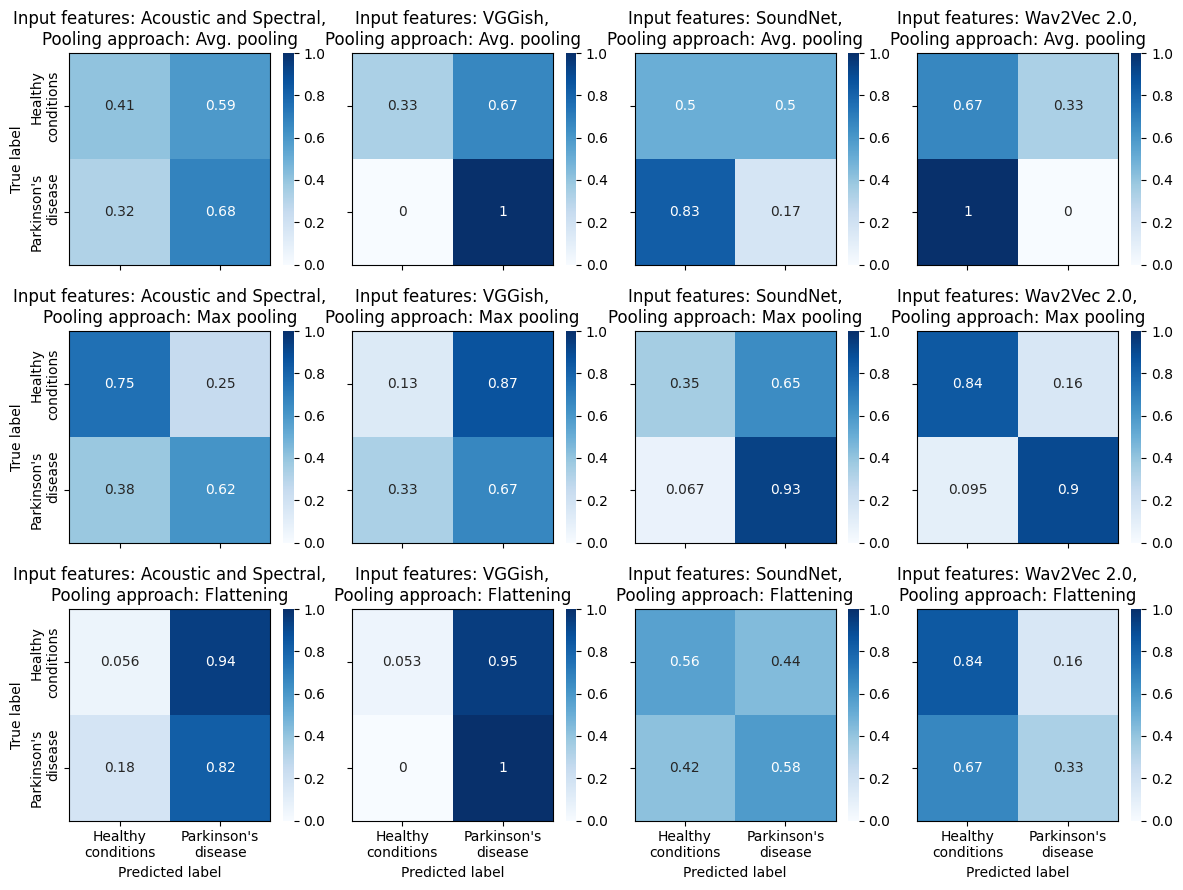

In [53]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [178]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_cm.pdf'))

## Transferring from Hindi to English

In [156]:
df_all = df_hi_to_en[
    (df_hi_to_en['Data set'] == DATA_MAPPING['tgt']) & (df_hi_to_en['Metric'].isin(METRICS))]
print(df_all)

            Input features Pooling approach              Domain adaptation  \
14   Acoustic and Spectral     Avg. pooling                           None   
15   Acoustic and Spectral     Avg. pooling                           None   
16   Acoustic and Spectral     Avg. pooling                           None   
17   Acoustic and Spectral     Avg. pooling                           None   
19   Acoustic and Spectral     Avg. pooling                           None   
..                     ...              ...                            ...   
659            Wav2Vec 2.0       Flattening  CORrelation ALignment (CORAL)   
660            Wav2Vec 2.0       Flattening  CORrelation ALignment (CORAL)   
661            Wav2Vec 2.0       Flattening  CORrelation ALignment (CORAL)   
663            Wav2Vec 2.0       Flattening  CORrelation ALignment (CORAL)   
664            Wav2Vec 2.0       Flattening  CORrelation ALignment (CORAL)   

        Data set       Metric     Value  
14   Target data     

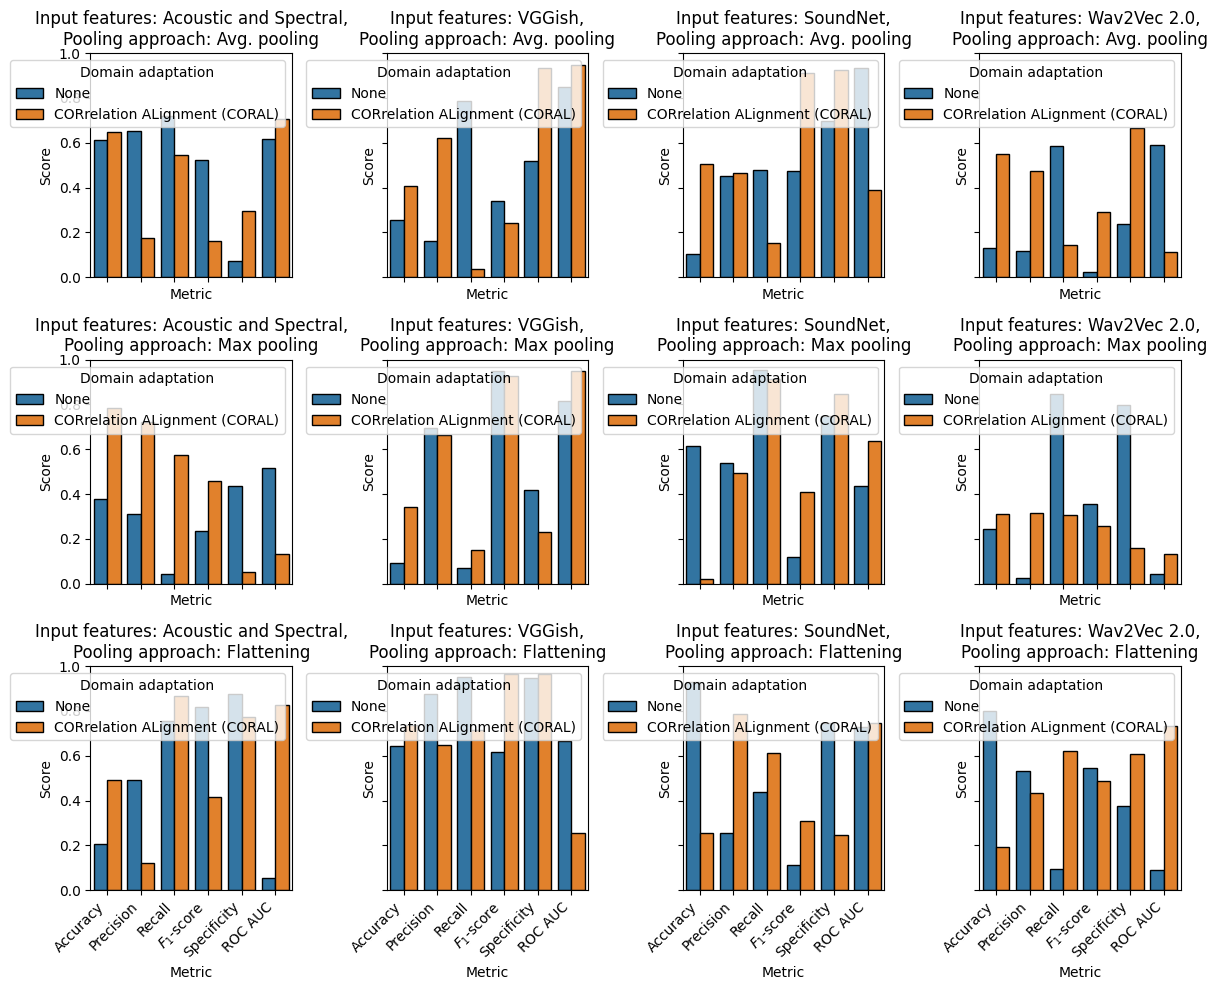

In [157]:
fig, axes = plt.subplots(
        nrows=len(df_all['Pooling approach'].unique()),
        ncols=len(df_all['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )



for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        
        sns.barplot(
            data=df_all[(df_all['Input features'] == feature) & (df_all['Pooling approach'] == pooling)],
            x='Metric',
            y='Value',
            ax=axes[i][j],
            linewidth=1.,
            edgecolor='0',
            order=list(METRICS),
            hue='Domain adaptation'
        )
       
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        axes[i][j].set_xlabel('Metric')
        axes[i][j].set_ylabel('Score')
        axes[i][j].set_ylim(0.0, 1.0)
        # axes[i][j].grid()
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [137]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_results.pdf'))

### ROC Curve

In [140]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_hi_to_en['Data set'] == DATA_MAPPING['tgt']) & df_hi_to_en['Metric'].isin(ROC)]
df_no_ad = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['tgt']) & df_hi_to_en['Metric'].isin(ROC)]


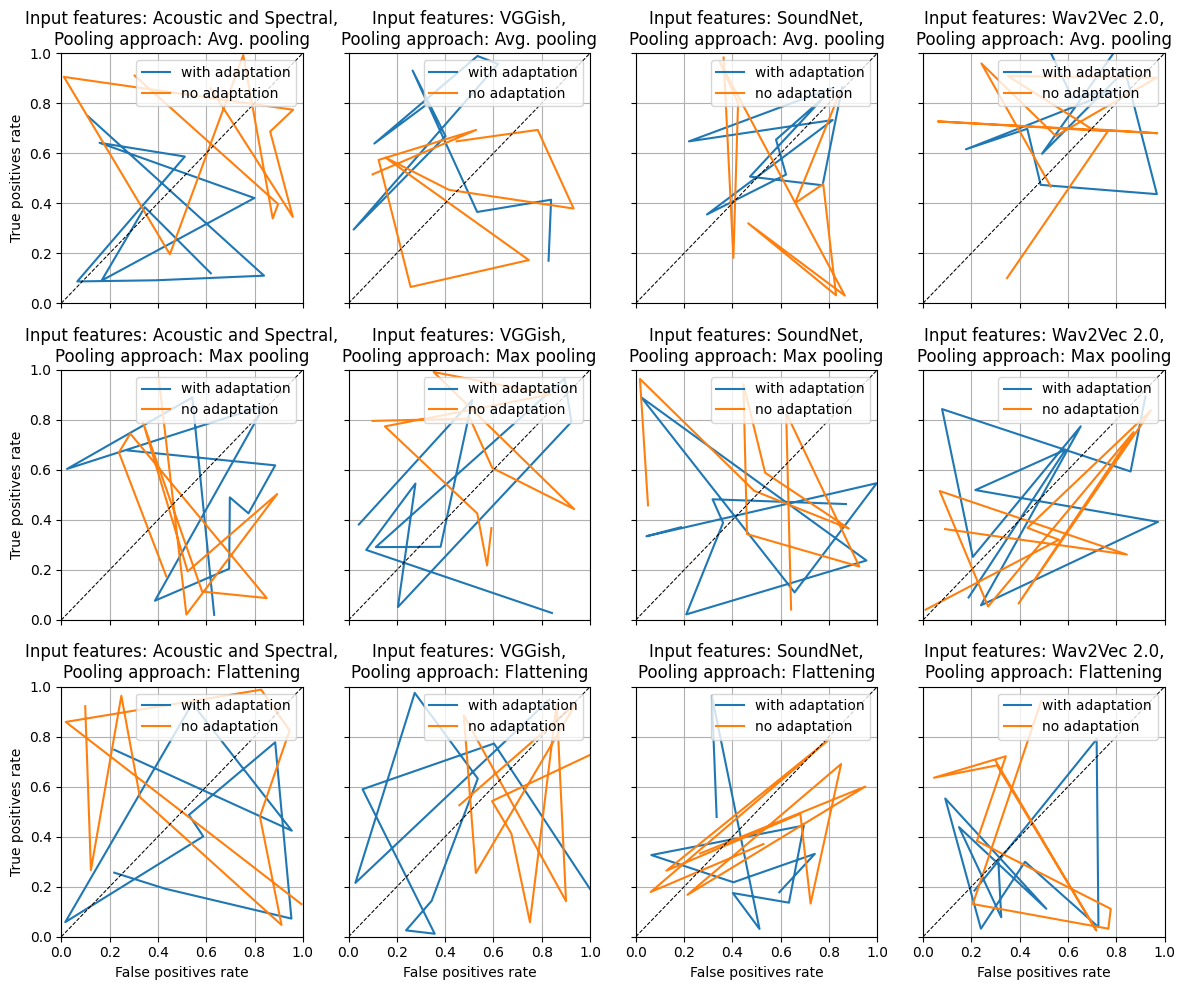

In [141]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'False positives rate')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'True postives rate')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'False positives rate')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'True postives rate')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label = "with adaptation")
        axes[i][j].plot(x_1, y_1, label = "no adaptation")
        axes[i][j].legend(loc='upper right')
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('False positives rate')
        if j == 0:
            axes[i][j].set_ylabel('True positives rate')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [142]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_roc_curve.pdf'))

### Precision-recall curve

In [145]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_hi_to_en['Data set'] == DATA_MAPPING['tgt']) & df_hi_to_en['Metric'].isin(PRC_REC)]
df_no_ad = df_hi_to_en[
     (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['tgt']) & df_hi_to_en['Metric'].isin(PRC_REC)]


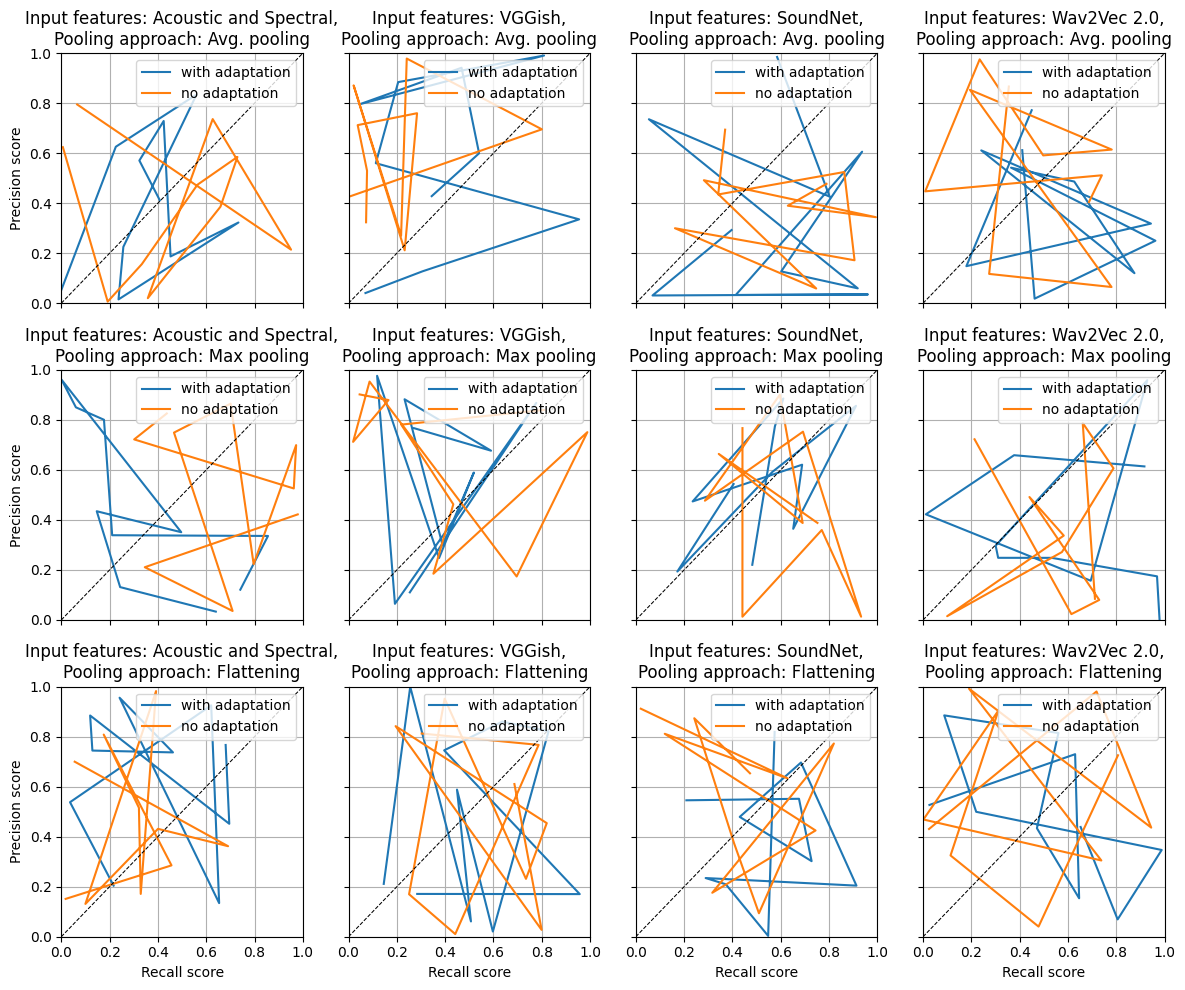

In [146]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 10),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        x = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Recall score')]['Value'].values[0]
        y = df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Precision score')]['Value'].values[0]
        
        x_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Recall score')]['Value'].values[0]
        y_1 =  df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Precision score')]['Value'].values[0]
        
        axes[i][j].plot(x, y, label = "with adaptation")
        axes[i][j].plot(x_1, y_1, label = "no adaptation")
        axes[i][j].legend(loc='upper right')
        axes[i][j].plot([0, 1], [0, 1], '--k', linewidth=0.75)
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Recall score')
        if j == 0:
            axes[i][j].set_ylabel('Precision score')
        axes[i][j].set_xlim(0.0, 1.0)
        axes[i][j].set_ylim(0.0, 1.0)
        axes[i][j].grid()

        # axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [147]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_pr_curve.pdf'))

### Confusion matrix

In [148]:
df = df_hi_to_en[
    (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[True]) & (df_hi_to_en['Data set'] == DATA_MAPPING['tgt']) & df_hi_to_en['Metric'].isin(CONF_MAT)]
df_no_ad = df_hi_to_en[
     (df_hi_to_en['Domain adaptation'] == ADAPTATION_MAPPING[False]) & (df_hi_to_en['Data set'] == DATA_MAPPING['tgt']) & df_hi_to_en['Metric'].isin(CONF_MAT)]


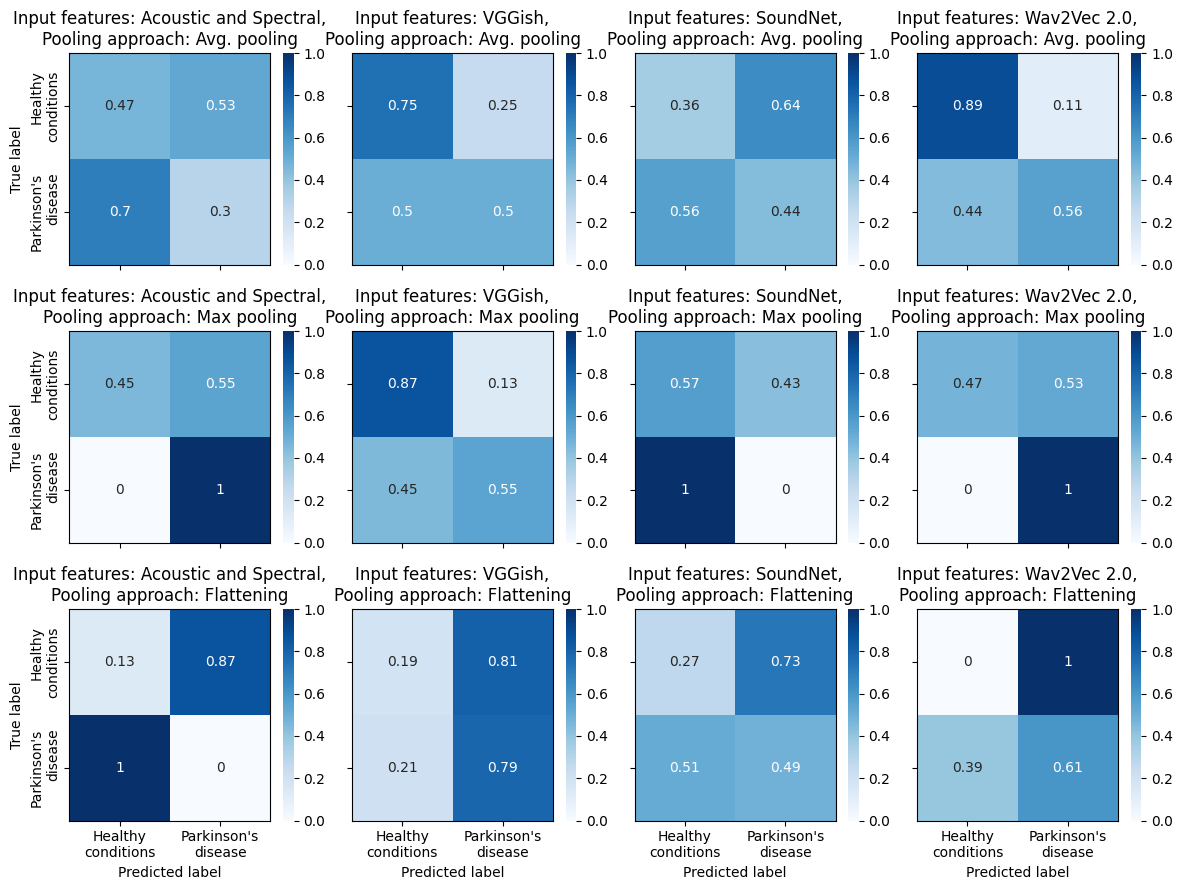

In [149]:
fig, axes = plt.subplots(
        nrows=len(df['Pooling approach'].unique()),
        ncols=len(df['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df[(df['Input features'] == feature) & (df['Pooling approach'] == pooling) & (df['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [150]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_with_adpt_cm.pdf'))

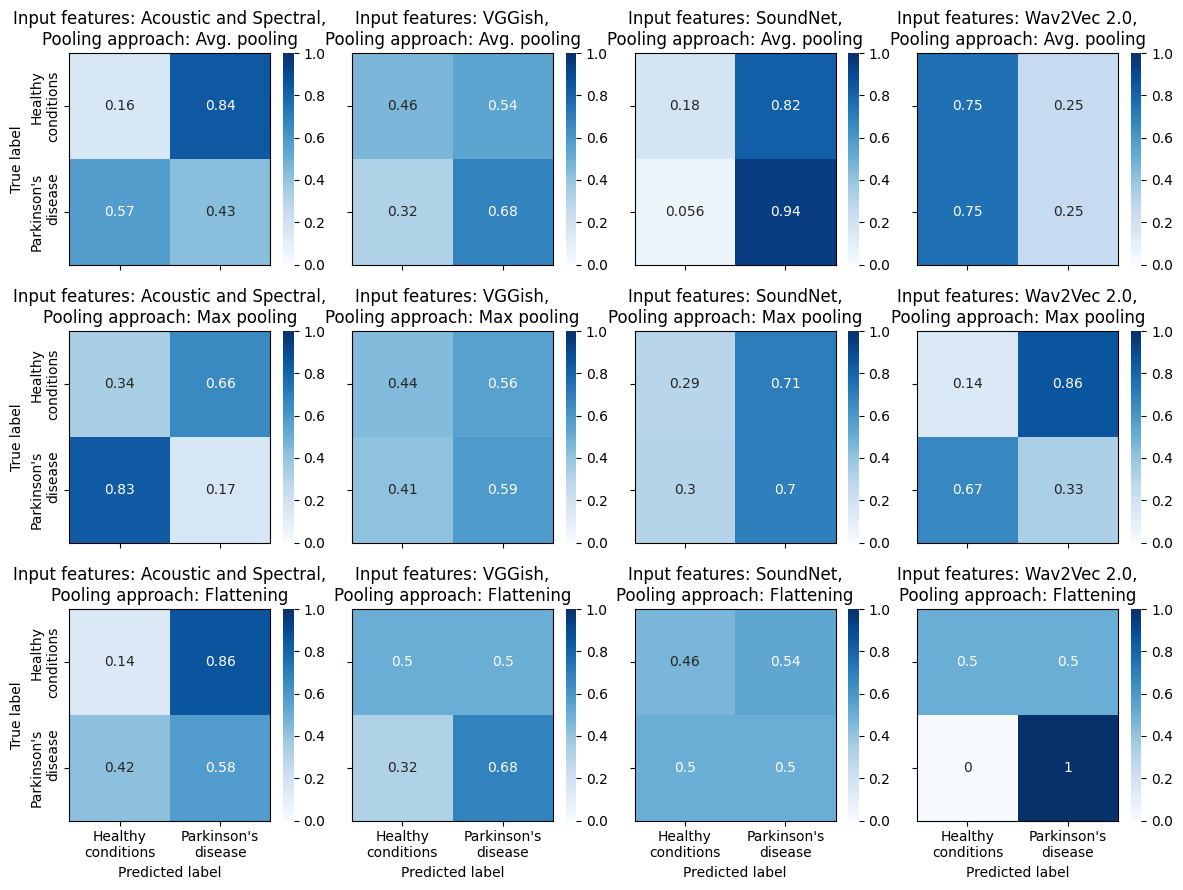

In [151]:
fig, axes = plt.subplots(
        nrows=len(df_no_ad['Pooling approach'].unique()),
        ncols=len(df_no_ad['Input features'].unique()),
        figsize=(12, 9),
        sharex=True,
        sharey=True  # 'row'
    )

for i, (_, pooling) in enumerate(POOLING_MAPPING.items()):
    for j, (_, feature) in enumerate(FEATURES_MAPPING.items()):
        mat = np.array(df_no_ad[(df_no_ad['Input features'] == feature) & (df_no_ad['Pooling approach'] == pooling) & (df_no_ad['Metric'] == 'Confusion matrix')]['Value'].values[0]).astype(float)
        mat /= mat.sum(1).reshape(-1, 1)
        
        hmap = sns.heatmap(
            mat, 
            cmap=plt.colormaps['Blues'], 
            vmin=0.0, 
            vmax=1.0, 
            ax=axes[i][j], 
            annot=True, 
            linecolor='0', 
            xticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'], 
            yticklabels=['Healthy\nconditions', 'Parkinson\'s\ndisease'],
        )
        sns.despine(ax=axes[i][j], top=False, right=False, left=False, bottom=False)
        sns.despine(ax=hmap, top=False, right=False, left=False, bottom=False)
        # fig.colorbar(mappable=mat, ax=axes[i][j])
        axes[i][j].set_title(f'Input features: {feature},\nPooling approach: {pooling}')
        if i == len(df['Pooling approach'].unique()) - 1:
            axes[i][j].set_xlabel('Predicted label')
        if j == 0:
            axes[i][j].set_ylabel('True label')
plt.tight_layout()
plt.show()

In [152]:
fig.savefig(os.path.join(OUT_DIR_PATH, 'hi_to_en_no_adpt_cm.pdf'))